# Проект "In One Click
---

**Краткое описание проекта**  
Интернет-магазин «В один клик» продаёт товары для детей, дома, мелкую бытовую технику, косметику и продукты. В последнее время наблюдается снижение активности покупателей. Вместо привлечения новых клиентов компания решила удерживать постоянных с помощью персонализированных предложений. Задача проекта — разработать модель машинного обучения для предсказания снижения покупательской активности и сегментировать клиентов для повышения их вовлечённости на основе анализа данных.

**Цели проекта**  
- Построить модель, предсказывающую вероятность снижения покупательской активности в следующие три месяца.  
- Проанализировать данные о коммуникациях, продуктовом и покупательском поведении, а также поведении на сайте.  
- Выделить сегменты клиентов на основе модели и данных о прибыльности, предложить стратегии повышения активности.  
- Оценить важность признаков и дать рекомендации для бизнеса.

**Данные для проекта**  
Данные предоставлены в четырёх таблицах:  
- `market_file.csv`: Данные о поведении на сайте, коммуникациях и продуктовом поведении (id, покупательская активность, тип сервиса, разрешить сообщать, маркет_актив_6_мес, маркет_актив_тек_мес, длительность, акционные_покупки, популярная_категория, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, страниц_за_визит).  
- `market_money.csv`: Данные о выручке (id, период, выручка).  
- `market_time.csv`: Данные о времени на сайте (id, период, минут).  
- `money.csv`: Данные о прибыли (id, прибыль).  

**План работы**  
Проект включает следующие этапы:  
1. **Загрузка данных**: Загрузить и проверить таблицы.  
2. **Предобработка данных**: Обработать пропуски, выбросы, преобразовать типы данных.  
3. **Исследовательский анализ данных**: Проанализировать таблицы, отобрать клиентов с активностью не менее трёх месяцев.  
4. **Объединение таблиц**: Объединить market_file, market_money, market_time; создать отдельные столбцы для периодов.  
5. **Корреляционный анализ**: Проверить мультиколлинеарность и устранить её при необходимости.  
6. **Использование пайплайнов**: Подготовить данные с ColumnTransformer, обучить модели (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC), подобрать гиперпараметры, выбрать лучшую по метрике (например, ROC-AUC).  
7. **Анализ важности признаков**: Использовать SHAP для оценки и визуализации.  
8. **Сегментация покупателей**: Выделить сегменты, проанализировать и предложить стратегии.  
9. **Общий вывод**: Подвести итоги.

**5. Отработка навыков**  
Начинающий специалист Data Science сможет отработать:  
- **Работа с данными**: Загрузка, предобработка, объединение таблиц, обработка категориальных и числовых признаков. (pandas) 
- **Исследовательский анализ (EDA)**: Визуализация (matplotlib/seaborn), статистика и фильтрация данных.  
- **Машинное обучение**: Построение пайплайнов (scikit-learn), кодирование (OneHotEncoder, OrdinalEncoder), масштабирование (StandardScaler, MinMaxScaler), модели классификации, подбор гиперпараметров (GridSearchCV) и др.  
- **Оценка моделей**: Выбор метрик (accuracy, precision, recall, F1, ROC-AUC), кросс-валидация.  
- **Интерпретация моделей**: Анализ важности признаков (SHAP).  
- **Бизнес-анализ**: Сегментация, рекомендации на основе данных. 

In [1]:
! pip install phik -q

In [2]:
! pip install shap -q

In [3]:
! pip install --upgrade scikit-learn -q

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder, 
    MinMaxScaler,
    LabelEncoder
)
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, 
    make_scorer,
    confusion_matrix,
    recall_score
)
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

**Функции для загрузки и вывода общей информации о загруженных данных**

In [5]:
def load_data(filename, sep=',', decimal=','):
    # Пробуем разные пути к файлу
    file_paths = [
        f'/datasets/{filename}',  # Абсолютный путь
        f'datasets/{filename}',   # Относительный путь
        f'../datasets/{filename}'  # На случай если скрипт в подпапке
        f'{filename}'  # На случай если скрипт в 
    ]
    
    for path in file_paths:
        if os.path.exists(path):
            try:
                df = pd.read_csv(path,
                                 sep=sep,
                                 decimal=decimal,
                                 encoding='utf-8',
                                 error_bad_lines=False, 
                                 warn_bad_lines=True)
                print(f"Файл успешно загружен из: {path}")
                return df
            except Exception as e:
                print(f"Ошибка при загрузке файла {path}: {e}")
                continue
    
    # Если ни один файл не найден
    raise FileNotFoundError(f"Не удалось найти файл {filename} ни по одному из путей: " + ", ".join(file_paths))


In [6]:
def separator():
    print('='*70)

In [7]:
def show_data(df):
    separator()
    print("\nОбщая информация о датасете")
    separator()
    print(f'Количество строк: {df.shape[0]}')
    print(f'Количество столбцов: {df.shape[1]}')
    
    print("\nИнформация о столбцах:")
    separator()
    print(df.info())
    
    print("\nПервые 5 строк датасета:")
    separator()
    display(df.head().style)

In [8]:
try:
    market_file = load_data('market_file.csv', decimal='.')
except Exception as e:
    print(f'Ошибка {e}')

pd.set_option('display.max_columns', None)
show_data(market_file)

Файл успешно загружен из: datasets/market_file.csv

Общая информация о датасете
Количество строк: 1300
Количество столбцов: 13

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_про

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400000,5,121,0.000000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400000,4,819,0.750000,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.900000,3,539,0.140000,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.200000,5,896,0.990000,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.100000,3,1064,0.940000,Товары для детей,3,2,3,2


In [9]:
try:
    market_money = load_data('market_money.csv' , decimal='.')
except Exception as e:
    print(f'Ошибка {e}')

show_data(market_money)

Файл успешно загружен из: datasets/market_money.csv

Общая информация о датасете
Количество строк: 3900
Количество столбцов: 3

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None

Первые 5 строк датасета:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.000000
1,215348,текущий_месяц,3293.100000
2,215348,предыдущий_месяц,0.000000
3,215349,препредыдущий_месяц,4472.000000
4,215349,текущий_месяц,4971.600000


In [10]:
try:
    market_time = load_data('market_time.csv')
except Exception as e:
    print(f'Ошибка {e}')

show_data(market_time)

Файл успешно загружен из: datasets/market_time.csv

Общая информация о датасете
Количество строк: 2600
Количество столбцов: 3

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None

Первые 5 строк датасета:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
try:
    money = load_data('money.csv', sep=';')
except Exception as e:
    print(f'Ошибка {e}')

show_data(money)

Файл успешно загружен из: datasets/money.csv

Общая информация о датасете
Количество строк: 1300
Количество столбцов: 2

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None

Первые 5 строк датасета:


,id,Прибыль
0,215348,0.980000
1,215349,4.160000
2,215350,3.130000
3,215351,4.870000
4,215352,4.210000


**Выводы:**
- Загружены данные с обработкой исключений (проверка нескольких путей) c разделителем `;`.
- Предусмотреа корректная загрузка числовых данных (`decimal=','`), \
  что в дальнейшем исключило необходимость в преобразовании типов данных в числовых столбцах.
- **Структура данных**:
  - `market_file.csv`: 1300 строк, 13 столбцов. Датасет с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
  - `market_money.csv`: 3900 строк, 3 столбца. Датасет с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
  - `market_time.csv`: 2600 строк, 3 столбца. Датасет с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
  - `money.csv`: 1300 строк, 2 столбца. Датасет с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
**ИТОГ:**  На первый взгляд данные корректны, но требуется проверка на пропуски, дубликаты и типы данных.

## Предобработка данных

In [12]:
def check_remove_duplicates(df, column_name=None, remove_duplicates=False, keep='first', n_rows=10):
    """
    Функция для проверки  и удаления дубликатов
    
    Параметры:
    df - DataFrame
    column_name - имя столбца (None для всего датафрейма) (по умолчанию column_name=None)
    remove_duplicates - флаг для удаления дубликатов (по умолчанию remove_duplicates=False)
    keep - какие дубликаты сохранять ('first', 'last', False) (по умолчанию keep='first')
    n_rows - количество строк которые для вывода в примере df с дубликатами (int) (по умолчанию n_rows=10)
    
    Возвращает: обработанный DataFrame
    """
    subset = [column_name] if column_name else None
    text = f"в столбце '{column_name}'" if column_name else "во всем датафрейме"

    #вычисление статистики
    dup_mask = df.duplicated(subset=subset, keep=False)
    total = len(df)
    dup_count = dup_mask.sum()
    dup_pct = (dup_count / total) * 100 if total > 0 else 0

    # Вывод статистики
    print(f"Анализ дубликатов {text}:")
    separator()
    print(f"Всего записей: {total}")
    print(f"Дубликатов: {dup_count}")
    print(f"Процент: {dup_pct:.2f}%")

    # Вывод примеров
    if dup_count > 0:
        print("\nПримеры дублирующихся строк:")    
        if column_name:
            display(df[dup_mask].sort_values(by=column_name).head(n_rows))
        else:
            display(df[dup_mask].sort_values(by=df.columns.tolist()).head(n_rows))
    
    # Удаление дубликатов
    if remove_duplicates:
        start = len(df)
        df = df.drop_duplicates(subset=subset, keep=keep)
        removed = start - len(df)
        separator()
        print("Результат удаления:")
        separator()
        print(f"Удалено: {removed}")
        print(f"Осталось: {len(df)}")
        
        if removed > 0:
            new_dup = df.duplicated(subset=subset, keep=False).sum()
            new_pct = (new_dup / len(df)) * 100 if len(df) > 0 else 0
            print(f"Текущие дубликаты: {new_dup}")
            print(f"Текущий процент: {new_pct:.2f}%")

    separator()
    print('\n')
    return df if remove_duplicates else None

In [13]:
def unique_cat(df, column):
    
    print('\n')
    print(f"Анализ столбца '{column}':")
    separator()
    print("Количество уникальных значений:", df[column].nunique())
    print("Уникальные значения:")
    print(df[column].value_counts().sort_index())
    separator()

### Проверка на пропуски

In [14]:
df_dict={'market_file': market_file, 'market_money': market_money, 
'market_time': market_time, 'money': money}

for df_name, df in df_dict.items():
    print(f'\nПроверка на пропуски в датафрейме: {df_name}')
    print(df.isna().sum())
    separator()


Проверка на пропуски в датафрейме: market_file
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Проверка на пропуски в датафрейме: market_money
id         0
Период     0
Выручка    0
dtype: int64

Проверка на пропуски в датафрейме: market_time
id        0
Период    0
минут     0
dtype: int64

Проверка на пропуски в датафрейме: money
id         0
Прибыль    0
dtype: int64


**Выводы**

Пропуски в данных не обрнаружены

### Проверка на дубликаты и ошибки

In [15]:
categorical_cols =  market_file.select_dtypes(include=['object']).columns

for col in categorical_cols:
    unique_cat(market_file, col)



Анализ столбца 'Покупательская активность':
Количество уникальных значений: 2
Уникальные значения:
Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64


Анализ столбца 'Тип сервиса':
Количество уникальных значений: 3
Уникальные значения:
премиум      376
стандарт     914
стандартт     10
Name: Тип сервиса, dtype: int64


Анализ столбца 'Разрешить сообщать':
Количество уникальных значений: 2
Уникальные значения:
да     962
нет    338
Name: Разрешить сообщать, dtype: int64


Анализ столбца 'Популярная_категория':
Количество уникальных значений: 6
Уникальные значения:
Домашний текстиль                       251
Косметика и аксесуары                   223
Кухонная посуда                         138
Мелкая бытовая техника и электроника    174
Техника для красоты и здоровья          184
Товары для детей                        330
Name: Популярная_категория, dtype: int64


In [16]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({'стандартт':'стандарт'})
market_file['Тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

In [17]:
check_remove_duplicates(market_file, column_name='id')

Анализ дубликатов в столбце 'id':
Всего записей: 1300
Дубликатов: 0
Процент: 0.00%




In [18]:
categorical_cols =  market_money.select_dtypes(include=['object']).columns

for col in categorical_cols:
    unique_cat(market_money, col)

check_remove_duplicates(market_money)



Анализ столбца 'Период':
Количество уникальных значений: 3
Уникальные значения:
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
Name: Период, dtype: int64
Анализ дубликатов во всем датафрейме:
Всего записей: 3900
Дубликатов: 0
Процент: 0.00%




In [19]:
check_remove_duplicates(market_money)

Анализ дубликатов во всем датафрейме:
Всего записей: 3900
Дубликатов: 0
Процент: 0.00%




In [20]:
categorical_cols =  market_time.select_dtypes(include=['object']).columns

for col in categorical_cols:
    unique_cat(market_time, col)

check_remove_duplicates(market_time)




Анализ столбца 'Период':
Количество уникальных значений: 2
Уникальные значения:
предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64
Анализ дубликатов во всем датафрейме:
Всего записей: 2600
Дубликатов: 0
Процент: 0.00%




In [21]:
market_time['Период'] = market_time['Период'].replace({'предыдцщий_месяц':'предыдущий_месяц'})
market_time['Период'].value_counts()

предыдущий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

In [22]:
check_remove_duplicates(market_time)

Анализ дубликатов во всем датафрейме:
Всего записей: 2600
Дубликатов: 0
Процент: 0.00%




### Переименование столбцов в соответствии  с PEP8 

Избавимся от кирилицы, заглавных букв, и пробелов в названиях столбцов

In [23]:
new_columns_market_file = {
    'id' : 'id', 
    'Покупательская активность': 'customer_activity', 
    'Тип сервиса': 'service_type', 
    'Разрешить сообщать': 'promotional_consent', 
    'Маркет_актив_6_мес': 'avg_marketing_6month', 
    'Маркет_актив_тек_мес': 'avg_marketing_cur_month', 
    'Длительность':'account_age_days', 
    'Акционные_покупки': 'promo_purchases', 
    'Популярная_категория':'primary_category', 
    'Средний_просмотр_категорий_за_визит': 'mean_categories_viewed_visit', 
    'Неоплаченные_продукты_штук_квартал': 'unpaid_products_count_3m', 
    'Ошибка_сервиса':'service_error', 
    'Страниц_за_визит' : 'mean_pages_viewed_visit'
}

original_columns_market_file = {
    'id': 'id',
    'customer_activity': 'Покупательская активность',
    'service_type': 'Тип сервиса',
    'promotional_consent': 'Разрешить сообщать',
    'avg_marketing_6month': 'Маркет_актив_6_мес',
    'avg_marketing_cur_month': 'Маркет_актив_тек_мес',
    'account_age_days': 'Длительность',
    'promo_purchases': 'Акционные_покупки',
    'primary_category': 'Популярная_категория',
    'mean_categories_viewed_visit': 'Средний_просмотр_категорий_за_визит',
    'unpaid_products_count_3m': 'Неоплаченные_продукты_штук_квартал',
    'service_error': 'Ошибка_сервиса',
    'mean_pages_viewed_visit': 'Страниц_за_визит'
}


new_columns_market_money = {
    'id' : 'id', 
    'Период': 'reporting_period', 
    'Выручка': 'revenue'
}

original_columns_market_money = {
    'id': 'id',
    'reporting_period': 'Период',
    'revenue': 'Выручка'
}

new_columns_market_time = {
    'id' : 'id', 
    'Период': 'period_name', 
    'минут': 'minutes_on_site'
}

original_columns_market_time = {
    'id': 'id',
    'period_name': 'Период',
    'minutes_on_site': 'минут'
}



new_columns_money = {
    'id' : 'id', 
    'Прибыль': 'avg_profit_last_3m'
}

original_columns_money = {
    'id': 'id',
    'avg_profit_last_3m': 'Прибыль'
}

In [24]:
market_file = market_file.rename(columns=new_columns_market_file)
market_money = market_money.rename(columns=new_columns_market_money)
market_time = market_time.rename(columns=new_columns_market_time)
money = money.rename(columns=new_columns_money)

In [25]:
display(market_file.head(2))
print()
display(market_money.head(2))
print()
display(market_time.head(2))
print()
display(money.head(2))



,id,customer_activity,service_type,promotional_consent,avg_marketing_6month,avg_marketing_cur_month,account_age_days,promo_purchases,primary_category,mean_categories_viewed_visit,unpaid_products_count_3m,service_error,mean_pages_viewed_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


,id,reporting_period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


,id,period_name,minutes_on_site
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13


,id,avg_profit_last_3m
0,215348,0.98
1,215349,4.16


**Выводы**
1.  Загружены данные с обработкой исключений (проверка нескольких путей) c разделителем `;`.  
    Предусмотреа корректная загрузка числовых данных (`decimal=','`), \
    что в дальнейшем исключило необходимость в преобразовании типов данных в числовых столбцах.
2. Типы данных в столбцах корректные
3. **Пропуски**: Пропуски отсутствуют во всех датасетах.
4. **Дубликаты, ошибки**: 
    - В датасете `market_file` в столбце `'Тип сервиса'` обнаружена ошибка**\
      `стандартт` и `стандарт` приведены к одному значению - `стандартт`
    - В датасете `market_time` в столбце `'Период'` обнаружена ошибка**\
      `предыдцщий_месяц` приведен к значению - `предыдущий_месяц`
5. Проведено переименование столбцов в датаетах\ 
    Переименование столбцов в датасетах необходимо для:  
   - **Улучшения совместимости** с библиотеками Python, которые лучше работают с латинскими символами  
   - **Удобства** написания кода (snake_case вместо пробелов и спецсимволов)  
   - **Стандартизации** названий в соответствии с PEP 8  
- Столбцы переименованы по стандарту PEP8 (snake_case)
- Удалена кириллица и пробелы из названий столбцов
- Названия столбцов понятны и отражают их содержание.
- Созранены оригинальные названия столбцов для 

<b>Таблицы переимневания</b>
<details>
<summary><b>Датасет "market_file" </summary></b>

|      Старое название      |      Новое название      |
|---------------------------|--------------------------|
|   id  |   id     |
| Покупательская активность |     customer_activity    |
| Тип сервиса | service_type |
| Разрешить сообщать | promotional_consent |
| Маркет_актив_6_мес | avg_marketing_6month |
| Маркет_актив_тек_мес | avg_marketing_cur_month |
| Длительность | account_age_days |
| Акционные_покупки | promo_purchases |
| Популярная_категория | primary_category |
| Средний_просмотр_категорий_за_визит | mean_categories_viewed_visit |
| Неоплаченные_продукты_штук_квартал | unpaid_products_count_3m |
| Ошибка_сервиса | service_error |
| Страниц_за_визит | mean_pages_viewed_visit |
</details>
<p>
<details>
<summary><b>Датасет "market_money" </summary></b>

| Старое название | Новое название |
|----------------|----------------|
| id | id |
| Период | reporting_period |
| Выручка | revenue |

</details>
<p>

<details>
<summary><b>Датасет "market_time" </summary></b>

| Старое название | Новое название |
|----------------|----------------|
| id | id |
| Период | period_name |
| минут | minutes_on_site |

</details>
<p>

<details>
<summary><b>Датасет "money" </summary></b>

| Старое название | Новое название |
|----------------|----------------|
| id | id |
| Прибыль | avg_profit_last_3m |

</details>   
<p>
<b>Итог</b>: Данные очищены и готовы для дальнейшего анализа.

## Исследовательский анализ данных

### Исследовательский анализ данных `market_file`

In [26]:
def create_pie_chart(ax, values, labels, title, color_map='tab20'):

    # Ограничиваем количество цветов до числа сегментов
    try:
        cmap = plt.get_cmap(color_map)
    except ValueError:
        cmap = plt.get_cmap('tab20')  # Запасной вариант при неверной цветовой карте
    colors = [cmap(i / len(values)) for i in range(len(values))]

  
    ax.pie(
        values,
        labels=labels,
        # Форматируем подписи и проценты
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(values))})',
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 9}
    )
    
    ax.set_title(title, pad=20, fontsize=12)
    ax.axis('equal')

In [27]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1300 non-null   int64  
 1   customer_activity             1300 non-null   object 
 2   service_type                  1300 non-null   object 
 3   promotional_consent           1300 non-null   object 
 4   avg_marketing_6month          1300 non-null   float64
 5   avg_marketing_cur_month       1300 non-null   int64  
 6   account_age_days              1300 non-null   int64  
 7   promo_purchases               1300 non-null   float64
 8   primary_category              1300 non-null   object 
 9   mean_categories_viewed_visit  1300 non-null   int64  
 10  unpaid_products_count_3m      1300 non-null   int64  
 11  service_error                 1300 non-null   int64  
 12  mean_pages_viewed_visit       1300 non-null   int64  
dtypes: 

In [28]:
market_file.describe()

,id,avg_marketing_6month,avg_marketing_cur_month,account_age_days,promo_purchases,mean_categories_viewed_visit,unpaid_products_count_3m,service_error,mean_pages_viewed_visit
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


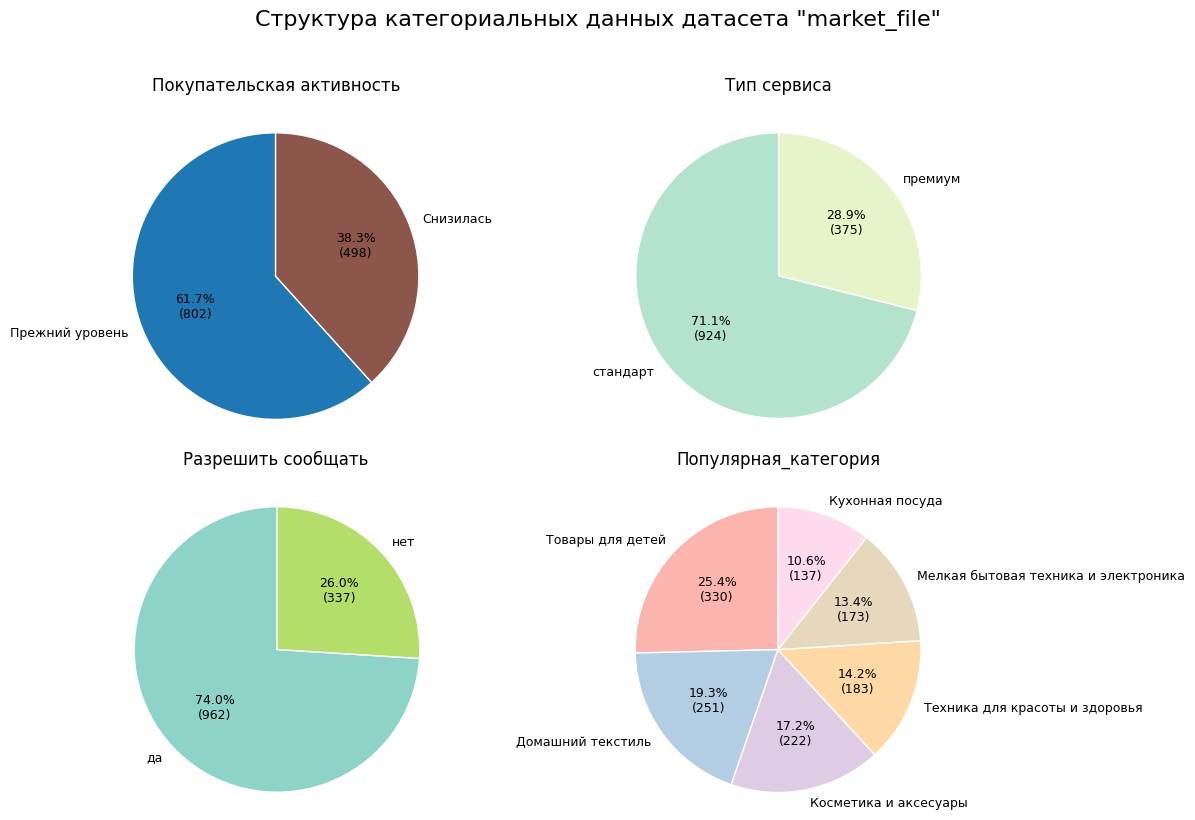

In [29]:
# Подготовка данных для диаграмм
data_to_plot = [
    {
        'series': market_file['customer_activity'].value_counts(), 
        'title': original_columns_market_file['customer_activity'], 
        'color_map': 'tab20'
     },
    {
        'series': market_file['service_type'].value_counts(), 
        'title': original_columns_market_file['service_type'], 
        'color_map': 'Pastel2'
        },
    {
        'series': market_file['promotional_consent'].value_counts(), 
        'title': original_columns_market_file['promotional_consent'], 
        'color_map': 'Set3'
        },
    {
        'series': market_file['primary_category'].value_counts(), 
        'title': original_columns_market_file['primary_category'], 
        'color_map': 'Pastel1'
        }
]

# Создание подграфиков
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Построение диаграмм
for i, data in enumerate(data_to_plot):
    if i < len(axes):
        create_pie_chart(axes[i], 
                         data['series'].values, data['series'].index, 
                         data['title'], data['color_map'])

# Скрытие неиспользуемых осей
for ax in axes[len(data_to_plot):]:
    ax.axis('off')

plt.suptitle('Структура категориальных данных датасета "market_file"', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Выводы по анализу круговых диаграмм распределения категориальных данных**

---

1. Анализ столбца **"Покупательская активность"** (`customer_activity`)\
Бинарное распределение: категории "Прежний уровень" и "Снизилась"\
Эта диаграмма показывает бинарное распределение активности покупателей: "Прежний уровень" (61.7%, 802 наблюдения) и "Снизилась" (38.3%, 498 наблюдений).
Большинство клиентов , более 61%, сохраняют прежний уровень активности, что указывает на стабильность в поведении основной массы пользователей. Меньшая доля, около 38%, демонстрирует снижение активности, что может говорить о потенциальных проблемах, таких как потеря интереса или какие-то внешние факторы (например,экономические изменения).\
Доминирование категории "Прежний уровень" предполагает, что пока большинство клиентов магазина представляют относительно лояльную аудиторию. Однако почти 38% клиентов с снижением активности — это значительная группа, которую стоит изучить глубже. Это может помочь выявить причины оттока, например такие как неудовлетворенность сервисом, низкая промо активность в определенных категориях товаров или нехватка необходимого ассортимента.

2. Анализ столбца **"Тип сервиса"** (service_type)\
Бинарное распределение: категории "стандарт" и "премиум"\
Распределение по типам сервиса: "премиум" (28,9% - 375 наблюдений) и "стандарт" (71.1% - 924 наблюдения).\
Подавляющее большинство клиентов (71.1%) используют стандартный тип сервиса, в то время как премиум-версия охватывает менее трети аудитории. Это типичное распределение, где базовый доступ привлекает широкую аудиторию, а премиум — более вовлеченных или платежеспособных пользователей.
Если снижение активности чаще встречается среди стандартных пользователей, это может быть маркером для улучшения базового опыта.

3. Анализ столбца **"Разрешить сообщать"** (promotional_consent)
Бинарное распределение: "Да" и "Нет" 
Распределение и пропорции: Почти три четверти клиентов (74%) дали согласие на получение сообщений (промо, уведомления и пр.), что является высоким показателем вовлеченности и только 26% отказались.
Высокий уровень согласия свидетельствует о доверии к магазину и готовности пользователей к персональным предложениям, что открывает возможности для email, SMS и других уведомлений. 
4. Анализ столбца **"Популярная_категория"** (primary_category)\
Мультикласcное распределение с шестью категориями:

    - Товары для детей: 25.4% (330 наблюдений)
    - Кухонная посуда: 10.6% (137 наблюдений)
    - Мелкая бытовая техника и электроника: 13.4% (174 наблюдений)
    - Домашний текстиль: 19.3% (251 наблюдений)
    - Техника для красоты и здоровья: 14.2% (183 наблюдений)
    - Косметика и аксессуары: 17.2% (222 наблюдений)

    Наиболее популярной является **"Товары для детей"** (четверть аудитории), за ней следуют "Домашний текстиль" (19.3%) и "Косметика и аксессуары" (17.2%). Менее популярны "Кухонная посуда" (10.6%), что делает ее наименьшей категорией. Распределение относительно равномерное, без экстремального доминирования одной категории, но с фокусом на товары для дома и семьи.
    Доминирование категории **"Товаров для детей"** предполагает, что значительная часть аудитории — семьи с детьми, что может влиять на маркетинговые стратегии (семейные промо, сезонные акции).\
    Категории вроде **"Домашний текстиль"** и **"Косметика и аксессуары"** указывают на интерес женской аудитории.  Низкая доля "Кухонной посуды" может сигнализировать о слабости в этом сегменте (конкуренция,  недостаток асортимента, слабые промо-кампании). В целом, распределение отражает разнообразный ассортимент, но с акцентом на повседневные нужды для семей, что может быть полезно для планирования персональных предложений.

---

**Заключение**

На основе анализа диаграмм можно сказать что данные датасета `market_file` демонстрирует относительно стабильную и вовлеченную аудиторию.  
Большинство клиентов (более 60%) сохраняют покупательскую активность на прежнем уровне, предпочитают стандартный сервис (71%) и дают согласие на коммуникации (74%). Это указывает на лояльность и потенциал для роста, особенно среди группы с сниженной активностью (38%), которая может быть подвержена оттоку. Распределение популярных категорий подчеркивает фокус на семейных и бытовых товарах ("Товары для детей" — 25.4%, "Домашний текстиль" — 19.3%), что предполагает демографию среднего возраста с семьями, ориентированную на детей и домашний комфорт. Однако неравномерность в категориях (минимум 10.6% для "Кухонной посуды") может говорить о возможностях для расширения ассортимента или проведения промо-акций в слабых сегментах.

In [30]:
def analyze_feature(df, feature, bins=50, title=None, figsize=(12,5), delta_y=1, rename_columns = None):
   
    if rename_columns:
       text = f"параметра: {rename_columns[feature]}"
    elif title:
       text = f"параметра: {title}"
    else:
       text = f"параметра: {feature}"
    
    
    print("Анализ " + text)
    print("=" * 50)
    
    # описательная статистика
    print(f"\nОписательная статистика {text}:")
    stats = df[feature].describe().apply(lambda x: format(x, '0.2f'))
    #pint(stats.map(lambda x: locale.format_string("%.2f", x, grouping=True).replace(',', ' ')))
    print(stats)

    label = feature if title else title
    # Создаем финуру с несколькими  графиками
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize)
    plt.subplots_adjust(wspace=0.3)  # Увеличено пространство между графиками
    # задаем цета для графиков
    hist_color = '#3498db'  # Синий
    kde_color = '#e74c3c'   # Красный
    mean_color = '#16a085'  # Зеленый
    median_color = '#f39c12' # Оранжевый

    # строим гистограмму распределения
    sns.histplot(data=df[feature],
                 bins=bins,
                 edgecolor=hist_color,
                 linewidth=1,
                 alpha=0.6,
                 label='Распределение',
                 kde=True,
                 ax=ax1).lines[0].set_color(kde_color)
    
   # добавим линии среднего и медианы
    mean = df[feature].mean()
    median = df[feature].median()
    ax1.axvline(mean, color=mean_color, linestyle='--', 
                linewidth=2.5, label=f'Среднее: {mean:.2f}')
    ax1.axvline(median, color=median_color, linestyle=':', 
                linewidth=2.5, label=f'Медиана: {median:.2f}')
    
    # Настройки оформления
    ax1.set_title(f"Гистограмма распределения\n{text}", fontsize=14, pad=10)
    ax1.set_xlabel(title, fontsize=12)
    ax1.set_ylabel('Плотность', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10, framealpha=1, shadow=True)
   
    y_max = ax1.get_ylim()[1]  # Текущий максимум оси Y
    ax1.set_ylim(top=y_max * delta_y)  # Добавляем  отступа сверху чтобы легенда не заползала на график (при необходимости)


    # график "ящик с усами" (боксплот)
    box_color = '#3498db'
    sns.boxplot(x=df[feature], 
                color=box_color, 
                width=0.3, 
                linewidth=2, 
                # настроим отображение выбросов
                flierprops=dict(
                    marker='D', # ромб
                    markersize=5, 
                    markerfacecolor='#e74c3c'), 
                ax=ax2)
    ax2.set_title(f'"Ящик с усами" для\n{text}', fontsize=14, pad=10)
    ax2.set_xlabel('')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    
    plt.tight_layout(pad=3, h_pad=2, w_pad=3)
    plt.show()
    
# анализ выбросов  (правило 1.5 * IQR)
# Любая точка данных, которая на 1,5 IQR ниже первого квартиля или выше третьего, является выбросом

    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    print(f"\nМежквартильный размах: {iqr:.3f}")
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\nКоличество выбросов: {len(outliers)}")
    print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
    if len(outliers)>0:
        print("\nПримеры выбросов:")
        print(outliers[feature].head(10))
    
    return lower_bound, upper_bound

In [31]:
def remove_outliers(df, column, lower_bound=None, upper_bound=None):

    original_size = len(df)
# создаем маску фильтра и изначально включаем все строки 
# на тот случай если не заданы границы или хотя бы одна из границ не задана
    mask = True  
    
    if lower_bound is not None:
        mask = mask & (df[column] > lower_bound)
        
    if upper_bound is not None:
        mask = mask & (df[column] < upper_bound)
        
    result_size = len(df[mask])
    drop_count = original_size - result_size
    
    print(f"\nКоличество удаленных строк: {drop_count}")
    print("\nДоля удаленных строк: {:.2f}%".format((drop_count/original_size)*100))
    return df[mask]

Анализ параметра: Маркет_актив_6_мес

Описательная статистика параметра: Маркет_актив_6_мес:
count    1300.00
mean        4.25
std         1.01
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: avg_marketing_6month, dtype: object


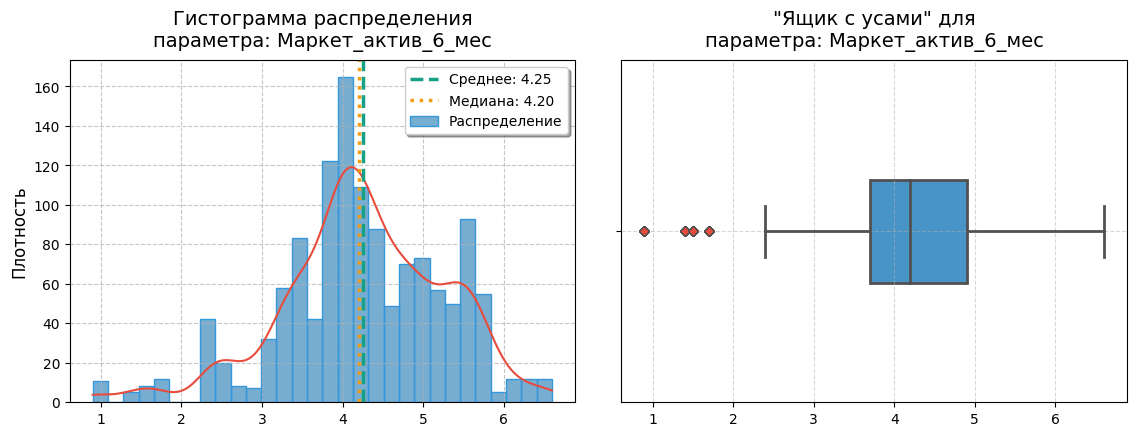


Межквартильный размах: 1.200

Количество выбросов: 36
Границы выбросов: [1.90, 6.70]

Примеры выбросов:
30     1.7
32     1.7
38     1.5
47     1.5
55     1.7
61     1.4
63     1.7
70     1.7
81     0.9
108    1.7
Name: avg_marketing_6month, dtype: float64


In [32]:
lower, upper = analyze_feature(market_file,'avg_marketing_6month', bins=30, rename_columns=original_columns_market_file)

**Выводы по анализу Маркет_актив_6_мес (`avg_marketing_6month`)**

---
**Маркет_актив_6_мес** - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на одного клиента.

Параметр **"Маркет_актив_6_мес"** демонстрирует стабильное распределение с центральными значениями около 4.2-4.25, что отражает умеренную вовлеченность большинства клиентов в маркетинговые активности платформы. Распределение близко к нормальному, с легкой левосторонней асимметрией, вызванной хвостом низких значений, и умеренным стандартным отклонением (1,01), указывающей на предсказуемость поведения. Узкий квартильный размах (4.9-3.7=1.20 ед.) подчеркивает концентрацию 50% данных в узком диапазоне от 3.70 до  4.90, что делает этот параметр достаточно надежным для сегментации, например нижняя квартиль — пассивные клиенты, верхняя — активные. Выбросы (36 случаев, все ниже 1.90) представляют небольшую, но важную группу с низкой активностью, возможно, связанную с оттоком или внешними факторами.

Так как выбросы не являются экстремальными и находяться в пределах разумных значений, удалять или обрабатывать их не стоит.

Анализ признака: Маркет_актив_тек_мес
Количество уникальных значений: 3
Уникальные значения: [3, 4, 5]

Описательная статистика:
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: avg_marketing_cur_month, dtype: float64

Распределение значений:
3    308
4    669
5    323
Name: avg_marketing_cur_month, dtype: int64


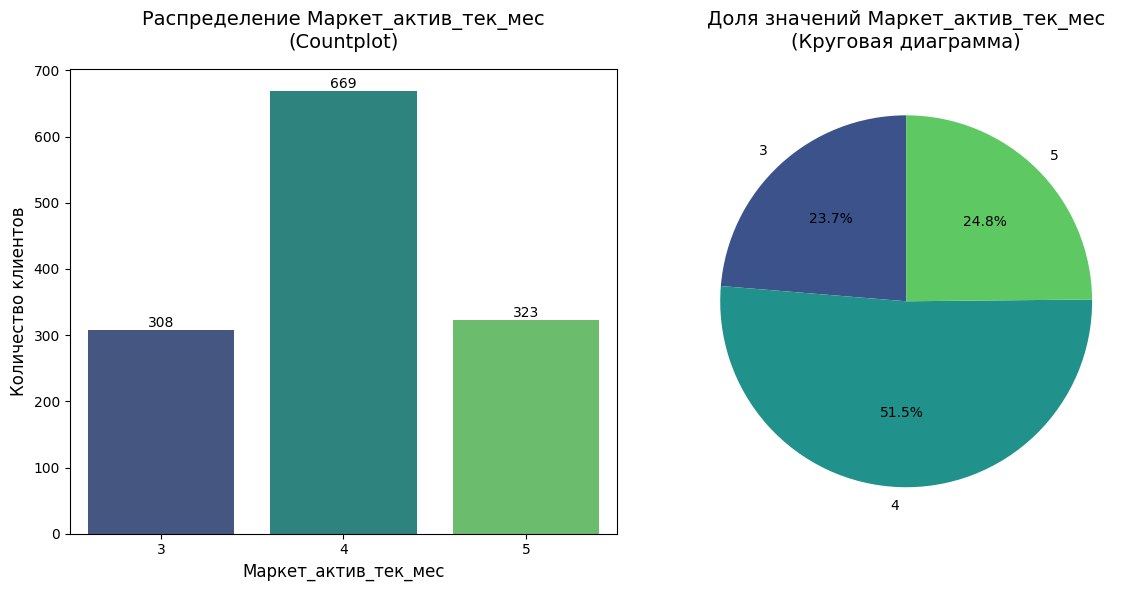

Дополнительный анализ:
Наиболее частое значение (Мода)): 4
Частота моды: 669


In [33]:
# Анализ дискретного признака avg_marketing_cur_month
separator()
print(f'Анализ признака: {original_columns_market_file["avg_marketing_cur_month"]}')
separator()


unique_values = market_file['avg_marketing_cur_month'].unique()
n_unique = market_file['avg_marketing_cur_month'].nunique()

print(f'Количество уникальных значений: {n_unique}')
print(f'Уникальные значения: {sorted(unique_values)}')


# Описательная статистика
print(f"\nОписательная статистика:")
print(market_file['avg_marketing_cur_month'].describe())

# Распределение значений
print(f"\nРаспределение значений:")
value_counts = market_file['avg_marketing_cur_month'].value_counts().sort_index()
print(value_counts)

# Построение графика countplot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
ax = sns.countplot(data=market_file, x='avg_marketing_cur_month', 
                   order=sorted(market_file['avg_marketing_cur_month'].unique()),
                   palette='viridis')
plt.title(f'Распределение {original_columns_market_file["avg_marketing_cur_month"]}\n(Countplot)', fontsize=14, pad=15)
plt.xlabel(original_columns_market_file['avg_marketing_cur_month'], fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)

# Добавляем подписи значений на столбцы
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

# Круговая диаграмма для дополнительной информации
plt.subplot(1, 2, 2)
value_counts.plot.pie(autopct='%1.1f%%', startangle=90, 
                      colors=sns.color_palette('viridis', len(value_counts)))
plt.title(f'Доля значений {original_columns_market_file["avg_marketing_cur_month"]}\n(Круговая диаграмма)', 
          fontsize=14, pad=15)
plt.ylabel('')

plt.tight_layout()
plt.show()

separator()
print(f'Дополнительный анализ:')
separator()
print(f"Наиболее частое значение (Мода)): {market_file['avg_marketing_cur_month'].mode().values[0]}")
print(f"Частота моды: {value_counts.max()}")

**Выводы по анализу Маркет_актив_тек_мес (`avg_marketing_cur_month`)**

---
**Маркет_актив_тек_мес** - количество маркетинговых коммуникаций в текущем месяце.

Гистограмма показывает три дискретных столбца с показателями 3, 4 и 5, и с доминирующим пиком на 4 ед.\
Доминирующее значение 4 ед.(51?5% данных) отражает стабильную, но не динамичную текущую маркетинговую активность клиентов.

Анализ параметра: Длительность

Описательная статистика параметра: Длительность:
count    1300.00
mean      601.90
std       249.86
min       110.00
25%       405.50
50%       606.00
75%       806.00
max      1079.00
Name: account_age_days, dtype: object


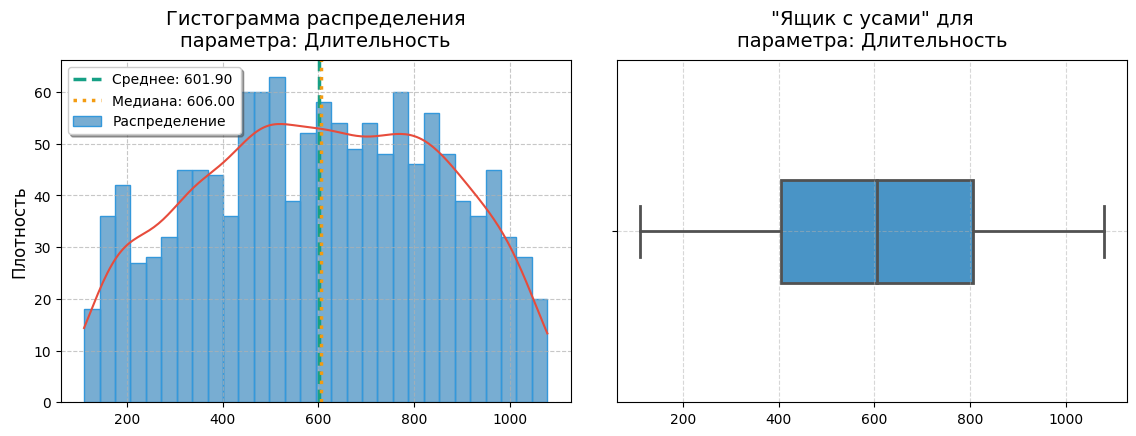


Межквартильный размах: 400.500

Количество выбросов: 0
Границы выбросов: [-195.25, 1406.75]


In [34]:
lower, upper = analyze_feature(market_file,'account_age_days', bins=30, rename_columns=original_columns_market_file)

**Выводы по анализу Длительность (`account_age_days`)**

---
**Длительность** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

1. Форма распределения приближена к нормальной\
   Линия плотности без резких спадов и пиков.
2. Распределение можно считать симметричным вокруг 600 дней. Медиана и среднее почти совпадают. 
3. Значительное стандартное отклонение в 250 дней указывает и межквартильный размах в 400 дней отражают значительную разницу в возрасте аккаунтов между нижней и верхней половинами выборки.
4. Выбросы отсутствуют что указывает на однородность и хорошее качество данных.

**Заключение**
Анализ **"Длительности"** (возраста) аккаунтов выявляет достаточно зрелую аудиторию магазина с высоким потенциалом лояльности, где большинство аккаунтов (около 75%) существуют более года, обеспечивая стабильную базу клиентов. Однако разнообразие возрастов (от 110 до 1079 дней) говорит о необходимости разнообразного подхода для поддержки новых пользователей (с возрастом аккаунта до 400 дней) для предотвращения оттока и активация старых (от 800-900 дней) для увеличения вовлеченности.


Анализ параметра: Акционные_покупки

Описательная статистика параметра: Акционные_покупки:
count    1300.00
mean        0.32
std         0.25
min         0.00
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: promo_purchases, dtype: object


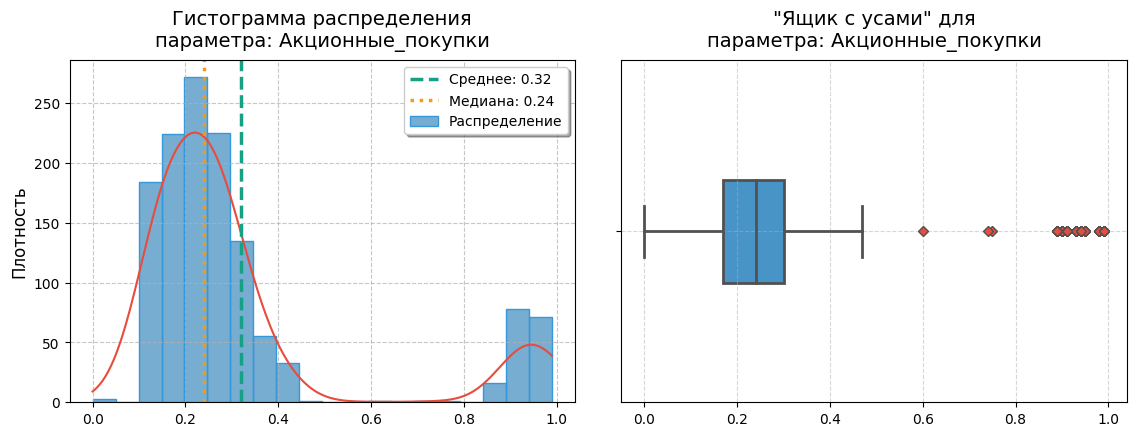


Межквартильный размах: 0.130

Количество выбросов: 168
Границы выбросов: [-0.02, 0.49]

Примеры выбросов:
1     0.75
3     0.99
4     0.94
14    0.74
16    0.98
17    0.95
25    0.90
26    0.98
27    0.89
28    0.98
Name: promo_purchases, dtype: float64


In [35]:
lower, upper = analyze_feature(market_file,'promo_purchases', bins=20, rename_columns=original_columns_market_file)

**Выводы по анализу "Акционные_покупки" (`promo_purchases`)**

---
**Акционные_покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев

1. Форма распределения скорее бимодальная, c двумя выраженными пиками в районе 25% и 90%
2. Значительная правосторонняя ассиметрия, (медиана 24% меньше среднего 32%). Правый хвост из-за высоких значений с пиком в районе 90-95%
3. четверть клиентов (Q1) имеет долю акционных покупок ниже 17%
4. верхняя четверть (Й3) имеет долю 30% но не достигает высоких значений.
5. Межквартильный размах достаточно узкий 1.3% что указывает на умеренную маркетингувую активность большинства клиентов,\
   в пределах 17-30%.
   
6. Количество выбросов: 168 (примерно 13% от выборки) — значительная доля, сосредоточенная в правом хвосте. что говорит о наличии клиентов которые готовы приобретать товары исключительно по акции.\
   Данные выбросы являются нормальными значениями и не требуют обработки или удаления.


**Заключение**\
Анализ параметра "Акционные_покупки" показывает смешанную картину. С одной стороны, магазин эффективно привлекает клиентов акциями (средняя 32%), но с другой показывает крайне неравномерную вовлечённость клиентов. Одна часть клиентов их игнорирует, а другая часть совершает покупки исключительно по скидкам. Это распределение показвает необходимость более разнообразного подхода для удержание низкоактивных клиентов(до 10% покупок) через новые форматы акций, и оптимизации акций для так называемых "охотников за скидками" (более 80% покупок) а так же дополнительно провести анализ рентабельности маркетинговых акций.

### Исследовательский анализ данных `market_money`

In [36]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3900 non-null   int64  
 1   reporting_period  3900 non-null   object 
 2   revenue           3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [37]:
market_money['revenue'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64

Анализ параметра: Выручка

Описательная статистика параметра: Выручка:
count      3900.00
mean       5025.70
std        1777.70
min           0.00
25%        4590.15
50%        4957.50
75%        5363.00
max      106862.20
Name: revenue, dtype: object


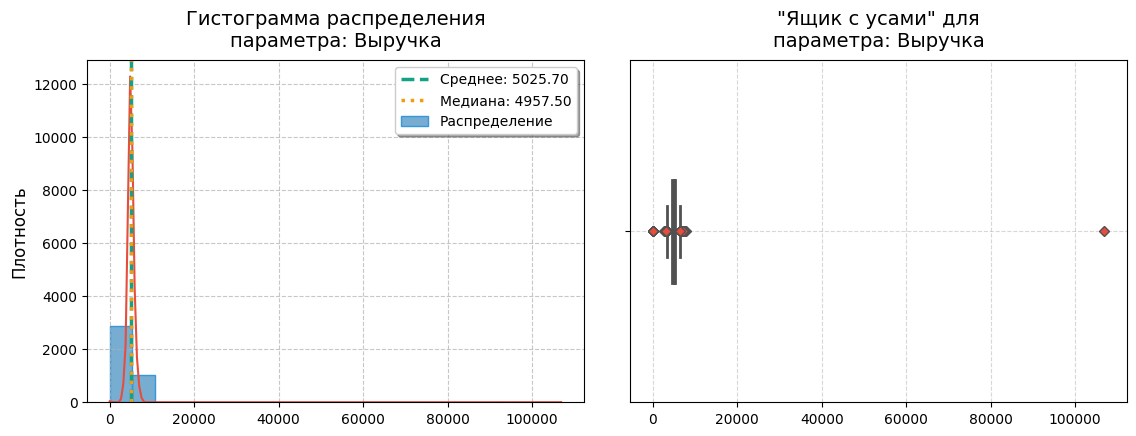


Межквартильный размах: 772.850

Количество выбросов: 175
Границы выбросов: [3430.87, 6522.28]

Примеры выбросов:
0        0.0
1     3293.1
2        0.0
9     6610.4
23    3263.0
28       0.0
29       0.0
34       0.0
35       0.0
69    6937.7
Name: revenue, dtype: float64


In [38]:
lower, upper = analyze_feature(market_money,'revenue', bins=20, rename_columns=original_columns_market_money)

**Обнаружен один экстремальный выброс**. в качестве метода обработки выброса выберем замену медианным значением.

In [39]:
def replace_outliers_with_median_percentile(df, column, lower_percentile=0, upper_percentile=99.9):
    """
    Заменяет выбросы медианным значением на основе процентилей
    """
    
    # Вычисляем границы по процентилям
    lower_bound = df[column].quantile(lower_percentile / 100)
    upper_bound = df[column].quantile(upper_percentile / 100)
    
    # Вычисляем медиану без учета выбросов
    median_value = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column].median()
    
    # Находим выбросы
    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    outliers_count = outliers_mask.sum()
    total_count = len(df)
    
    # Заменяем выбросы медианой
    df.loc[outliers_mask, column] = median_value
    
    # Статистика
    
    print('\nСтатистика')
    stats = {
        'Нижняя граница выьросов': lower_bound,
        'Верхнаяя граница выбросов': upper_bound,
        'Медиана': median_value,
        'Количество выбросов': outliers_count,
        'Процент выбросов': (outliers_count / total_count) * 100,
        'Количество измененных значений': outliers_count
    }
    
    for key, value in stats.items():
    # Определяем формат вывода в зависимости от типа значения
        if isinstance(value, float):
            print(f'{key}: {value:.2f}')  # Для чисел с плавающей точкой
        else:
            print(f'{key}: {value}')      # Для целых чисел
    
    return df

In [40]:
market_money = replace_outliers_with_median_percentile(market_money,'revenue')


Статистика
Нижняя граница выьросов: 0.00
Верхнаяя граница выбросов: 7548.73
Медиана: 4956.00
Количество выбросов: 4
Процент выбросов: 0.10
Количество измененных значений: 4


**Проводим повторный анализ**

Анализ параметра: Выручка

Описательная статистика параметра: Выручка:
count    3900.00
mean     4997.49
std       703.06
min         0.00
25%      4590.15
50%      4956.00
75%      5362.10
max      7547.80
Name: revenue, dtype: object


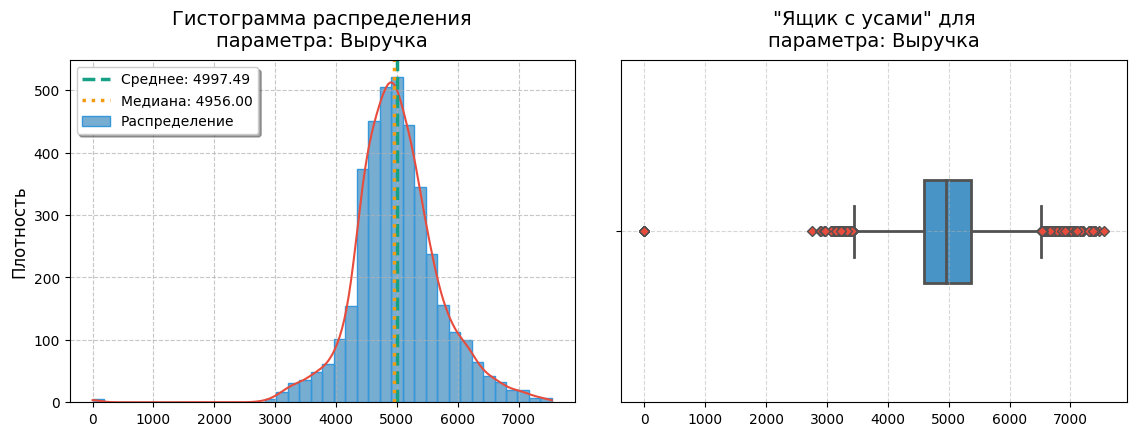


Межквартильный размах: 771.950

Количество выбросов: 172
Границы выбросов: [3432.22, 6520.03]

Примеры выбросов:
0        0.0
1     3293.1
2        0.0
9     6610.4
23    3263.0
28       0.0
29       0.0
34       0.0
35       0.0
69    6937.7
Name: revenue, dtype: float64


In [41]:
lower, upper = analyze_feature(market_money,'revenue', bins=40, rename_columns=original_columns_market_money )

**Посмотрим на распределение выручки в зависимости от периодов**

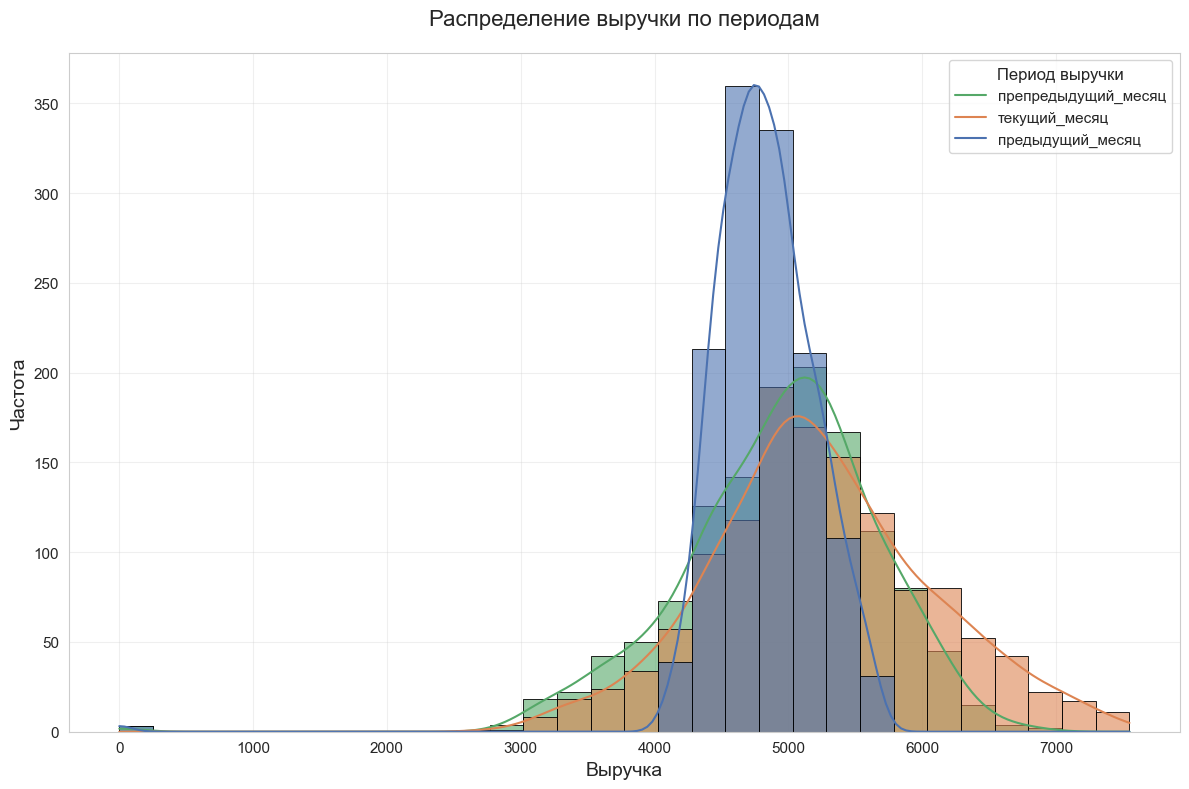

In [42]:
# создание гистограммы
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8)) 

# ключи для легенды
period_names = market_money['reporting_period'].unique()


# Построение гистограммы
plot = sns.histplot(
    data=market_money, 
    x='revenue', 
    hue='reporting_period', 
    bins=30, 
    alpha=0.6,
    palette='deep', 
    edgecolor='black',  
    linewidth=0.6,
    kde=True  
)

plt.title('Распределение выручки по периодам', fontsize=16, pad=20)
plt.xlabel('Выручка', fontsize=14)
plt.ylabel('Частота', fontsize=14)

legend = plt.legend(
    title='Период выручки',
    labels=period_names,
    title_fontsize=12,
    fontsize=11
)


# Несного улучшим шрифт
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.grid(True, alpha=0.3)

plt.tight_layout()  
plt.show()

In [43]:
period_names = market_money['reporting_period'].unique().tolist()
for period in period_names:
        print(f'Описательная статистика параметра "Выручка" в периоде {period}\n', market_money[market_money['reporting_period']==period]['revenue'].describe(), '\n')

Описательная статистика параметра "Выручка" в периоде препредыдущий_месяц
 count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: revenue, dtype: float64 

Описательная статистика параметра "Выручка" в периоде текущий_месяц
 count    1300.000000
mean     5230.345538
std       827.141817
min      2758.700000
25%      4706.050000
50%      5175.650000
75%      5748.450000
max      7547.800000
Name: revenue, dtype: float64 

Описательная статистика параметра "Выручка" в периоде предыдущий_месяц
 count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: revenue, dtype: float64 



**Выводы**

---

**Статистические показатели по месяцам:**

| Период | Среднее | Медиана | Std | Min | Max |
|--------|---------|---------|-----|-----|-----|
| Предпредыдущий месяц | 4825.21 | 4809 | 405.98 | 0 | 5663 |
| Предыдущий месяц | 4936.92 | 5005 | 739.60 | 0 | 6869.5 |
| Текущий месяц | 5236.57 | 5179.55 | 835.19 | 2758.7 | 7799.4 |

**Анализ графика (визуальный):**
- Распределение последовательно расширяется от месяца к месяцу
- Правый хвост становится более выраженным
- Пик распределения смещается вправо
- Исчезают нулевые значения в текущем месяце

**Ключевые изменения:**
- Среднее значение выросло на ~8.5% за два месяца
- Стандартное отклонение увеличилось более чем в 2 раза
- Минимальное значение сместилось от 0 до 2758.7
- Максимальное значение выросло на ~38%

**Заключение:**\
Наблюдается положительная динамика средних значений выручки при одновременном значительном росте вариативности данных. Исчезновение нулевых значений может указывать на улучшение качества данных или реальное увеличение минимальной выручки.

**Рекомендации для дальнейшего анализа:**

1. Выяснить причину почему в текущем периоде исчезли нулевые значения
2. Выявить факторы, влияющие на рост дисперсии


### Отбор клиентов с покупательской активностью не менее трёх месяцев

In [44]:

market_money_pivot =market_money.pivot_table(index='id', columns='reporting_period', values='revenue', aggfunc='sum').reset_index()
display(market_money_pivot.head(2))

new_columns_market_money_pivot = ['id', 'revenue_last_month', 'revenue_before_last_month', 'revenue_cur_month' ]
market_money_pivot = market_money_pivot.rename(columns=dict(zip(market_money_pivot.columns, new_columns_market_money_pivot)))
display(market_money_pivot.head(2))
original_columns_market_money_pivot={
    'id': 'id',
    'revenue_last_month': 'Выручка за прошлый месяц', 
    'revenue_before_last_month': 'Выручка за позапрошлый месяц', 
    'revenue_cur_month': 'Выручка за текущий месяц'
}

reporting_period,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6


reporting_period,id,revenue_last_month,revenue_before_last_month,revenue_cur_month
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6


In [45]:
id_active_clients = market_money_pivot[(market_money_pivot.iloc[:, 1:]>0).all(axis=1)]['id']

print('Общее количество клиентов:', len(market_money_pivot))
print('Количество клиентов активных в течении 3 месяцев:', len(id_active_clients))

Общее количество клиентов: 1300
Количество клиентов активных в течении 3 месяцев: 1297


**Всего 3 клиента не приобретали товары в магазине в течении последних 3-х месяцев**

In [46]:
filter_market_file = market_file[market_file['id'].isin(id_active_clients)]
filter_market_file

,id,customer_activity,service_type,promotional_consent,avg_marketing_6month,avg_marketing_cur_month,account_age_days,promo_purchases,primary_category,mean_categories_viewed_visit,unpaid_products_count_3m,service_error,mean_pages_viewed_visit
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


## Объединение таблиц
---

Для корректного объединения таблиц необходимо преобразовать преобразовать данные в датасетах `market_money` и `market_time` и создать единую систему данных на основе общего ключа 'id', который будет служить связующим звеном между всеми таблицами.

Так как данные в датасете `market_money` уже преобразованы,остается сделать аналогичное преобразование для датасета `market_time`

In [47]:

market_time_pivot =market_time.pivot_table(index='id', columns='period_name', values='minutes_on_site', aggfunc='sum').reset_index()
display(market_time_pivot.head(2))

new_columns_market_time_pivot = ['id', 'min_on_site_last_month', 'min_on_site_cur_month']
market_time_pivot = market_time_pivot.rename(columns=dict(zip(market_time_pivot.columns, new_columns_market_time_pivot)))
display(market_time_pivot.head(2))

original_columns_market_time_pivot={
    'id': 'id',
    'min_on_site_last_month': 'Время проведенное на сайте за прошлый месяц (мин)', 
    'min_on_site_cur_month': 'Время проведенное на сайте за текущий месяц (мин)'
}


period_name,id,предыдущий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10


period_name,id,min_on_site_last_month,min_on_site_cur_month
0,215348,13,14
1,215349,12,10


In [48]:
# Объединение данных
market_all = market_file.merge(market_money_pivot, on='id', how='left').merge(market_time_pivot, on='id', how='left')
display(market_all.head())


,id,customer_activity,service_type,promotional_consent,avg_marketing_6month,avg_marketing_cur_month,account_age_days,promo_purchases,primary_category,mean_categories_viewed_visit,unpaid_products_count_3m,service_error,mean_pages_viewed_visit,revenue_last_month,revenue_before_last_month,revenue_cur_month,min_on_site_last_month,min_on_site_cur_month
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [49]:
# Общий словарь для корректного отображения наименований значений на графиках
original_columns_market_all = original_columns_market_file | original_columns_market_money_pivot | original_columns_market_time_pivot
original_columns_market_all 

{'id': 'id',
 'customer_activity': 'Покупательская активность',
 'service_type': 'Тип сервиса',
 'promotional_consent': 'Разрешить сообщать',
 'avg_marketing_6month': 'Маркет_актив_6_мес',
 'avg_marketing_cur_month': 'Маркет_актив_тек_мес',
 'account_age_days': 'Длительность',
 'promo_purchases': 'Акционные_покупки',
 'primary_category': 'Популярная_категория',
 'mean_categories_viewed_visit': 'Средний_просмотр_категорий_за_визит',
 'unpaid_products_count_3m': 'Неоплаченные_продукты_штук_квартал',
 'service_error': 'Ошибка_сервиса',
 'mean_pages_viewed_visit': 'Страниц_за_визит',
 'revenue_last_month': 'Выручка за прошлый месяц',
 'revenue_before_last_month': 'Выручка за позапрошлый месяц',
 'revenue_cur_month': 'Выручка за текущий месяц',
 'min_on_site_last_month': 'Время проведенное на сайте за прошлый месяц (мин)',
 'min_on_site_cur_month': 'Время проведенное на сайте за текущий месяц (мин)'}

**Вывод**  

---

Таблицы объединены по ключу `'id'`. Созданы отдельные столбцы для периодов выручки и времени проведенного на сайте. \
Итоговый датасет `data` готов для моделирования. 

## Корреляционный анализ

In [50]:
market_all.head(2)

,id,customer_activity,service_type,promotional_consent,avg_marketing_6month,avg_marketing_cur_month,account_age_days,promo_purchases,primary_category,mean_categories_viewed_visit,unpaid_products_count_3m,service_error,mean_pages_viewed_visit,revenue_last_month,revenue_before_last_month,revenue_cur_month,min_on_site_last_month,min_on_site_cur_month
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10


In [51]:
# Получаем список всех столбцов с числовыми признаками
#num_cols = market_all.select_dtypes(include=['number']).columns.tolist()  

num_cols = [
    'avg_marketing_6month', 
    'account_age_days',
    'promo_purchases',
    'revenue_last_month',
    'revenue_before_last_month',
    'revenue_cur_month'    
]

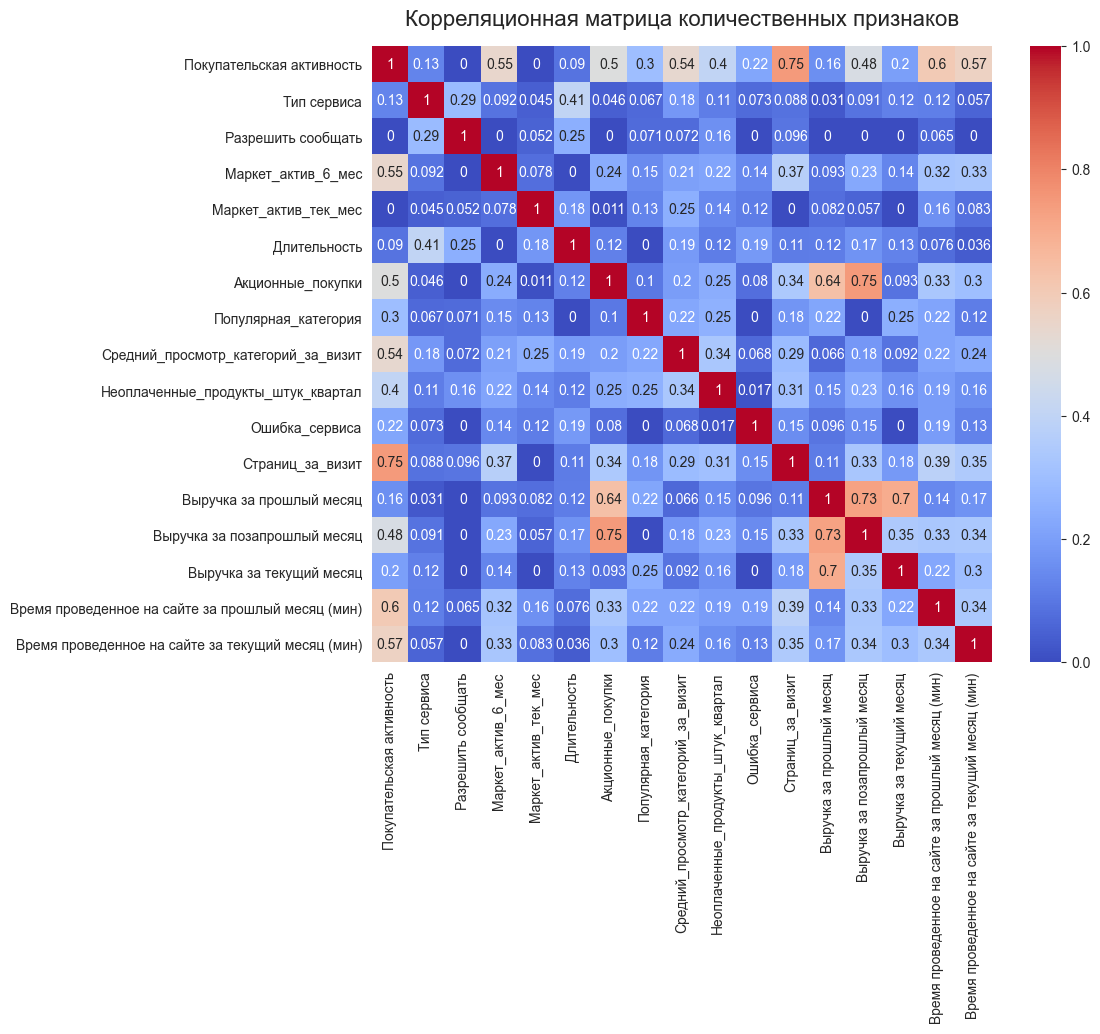

In [52]:
# Вычисление Phik-корреляции
phik_corr = market_all.drop(columns=['id']).phik_matrix(interval_cols=num_cols)
phik_corr = phik_corr.rename(columns=original_columns_market_all, index=original_columns_market_all)

plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляционная матрица количественных признаков', fontsize=16, y=1.02)
plt.show()

**Выводы**

---


1. **Покупательская активность** и :
    **Сильные корреляции**
  - **Страниц_за_визит** (φk ≈ 0.75)
  
    **Умеренные корреляции**
  - **Время проведенное на сайте за прошлый месяц (мин)** (φk ≈ 0.6) 
  - **Время проведенное на сайте за текущий месяц месяц (мин)** (φk ≈ 0.57)
  - **Средний просмотр категорий за визит** (φk ≈ 0.54)
  - **Маркет_актив_6_мес** (φk ≈ 0.55)
  - **Акционные покупки** (φk ≈ 0.5)
Более активное изучение сайта ведёт к повышению вовлечённости пользователей и, как следствие, к росту покупательской активности


2. **Выручка за прошлый месяц** и:
 - **Выручка за текущий месяц** (φk ≈ 0.76)
 

Высокую взаимную корреляцию между выручкой за прошлый и текущий периоды можно обосновать наличием стабильных, предсказуемых факторов, влияющих на её операционную деятельность компании. (постоянная клиентска база, наличие ходовых товарных позиций). финансоаве показателипрошлых периодов всегджа являются сильным предиктом для текущих периодов

для утранения переобучения потребуется удаление одного из параметров наприрмер выручки за прошлый период, `revenue_last_month`

**Слабые корреляции**
`Разрешить сообщать` явный кандидат на "шумовой" признак. Он имеет очень низкие корреляции (в основном, темно-синие ячейки) практически со всеми остальными переменными. Это означает, что согласие пользователя на получение информационных и рекламных сообщений не оказывает влияния на показатель покупательской активности, и остальные признаки. Возможно, это действие совершается один раз при регистрации и больше не отражает реального отношения клиента.




`Ошибка_сервиса`: Также демонстрирует очень слабые связи. Это может означать, что: 
  - ошибки происходят редко и не успевают повлиять на общую картину; 
  - система достаточно устойчива, и ошибки не вызывают оттока или снижения активности пользователей; 
  - это независимый фактор, который не связан с поведением пользователя.


---

**Практические выводы**  
- **Для ML-моделей**:  
  - Исключить слабые корреляционные связи: *Разрешить сообщать*
  - Исключить один период выручки (например выручку за позапрошлый период, `revenue_before_last_month`) для устранения переобучения моделей 
  

- **Для бизнеса**:  
  - Вовлечённость конвертируется в выручку: чем больше пользователи проводят времени на сайте и изучают страницы с карточками товаров, тем больше выручка
  - Акционные покупки показывают уверенную корреляцию (φk ≈ 0.64 с выручкой). (но необходимо проводить анализ эффективности маркетинговых акций)  

In [53]:
def scatt_plot(feature1, feature2, hue='customer_activity', data=market_all, categorical_feature=True):
            
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=data,
        x=feature1,
        y=feature2,
        hue=hue,
        style=hue,
        palette='Set1'
    )
    
    try:
        plt.title(
            f'Диаграмма рассеяния: "{original_columns_market_all[feature2]}" vs '
            f'"{original_columns_market_all[feature1]}"'
        )
        plt.xlabel(original_columns_market_all[feature1])
        plt.ylabel(original_columns_market_all[feature2])
    except KeyError as e:
        print(f'Ошибка: отсутствует ключ в original_columns_market_all - {e}')
        
    legend = plt.legend()
    legend.set_title(original_columns_market_all.get(hue, hue))
    plt.tight_layout()
    plt.show()

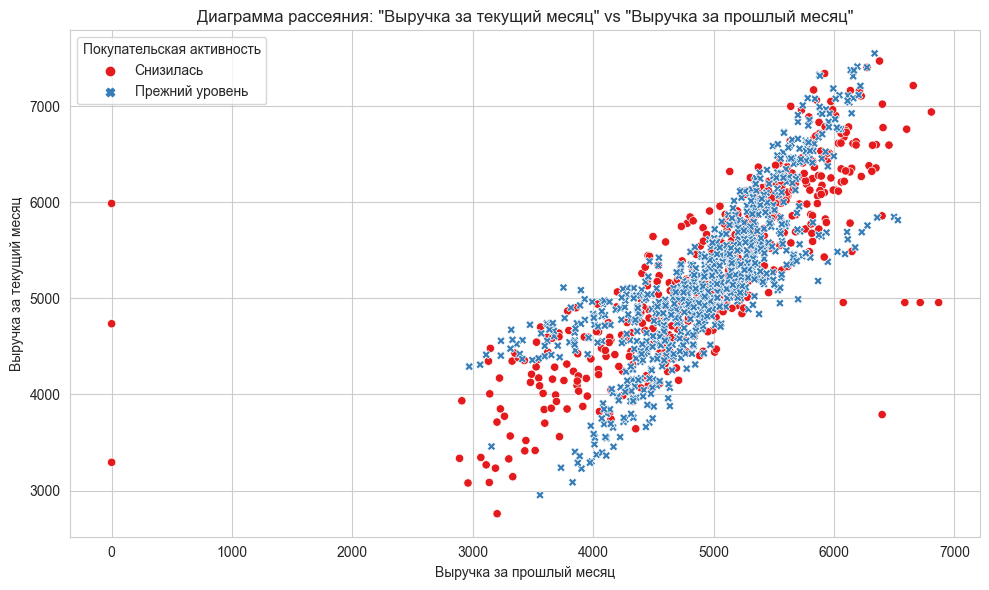

In [54]:
scatt_plot(feature1='revenue_last_month', feature2='revenue_cur_month')

**Выводы**

---

`Выручка за прошлый месяц` vs `Выручка за текущий месяц`

Наблюдается очень сильная положительная линейная корреляция. Точки формируют плотное облако, вытянутое вдоль диагональной линии. Это говорит о том, что доход клиента в текущем месяце тесно связан с его доходом в прошлом месяце.

группы точек почти равномерно перемешаны друг с другом. нельзя выявить закономерности для разделения

для группы c типои Покупательской активности 'снизилась ' четко видна линейная зависимость

для группы c типои Покупательской активности 'Прежний уровень' можно наблюдать как будто 2 отдельных линейных графика. возможно в данной группе клиентов есть дополнительное разделение на сегменты

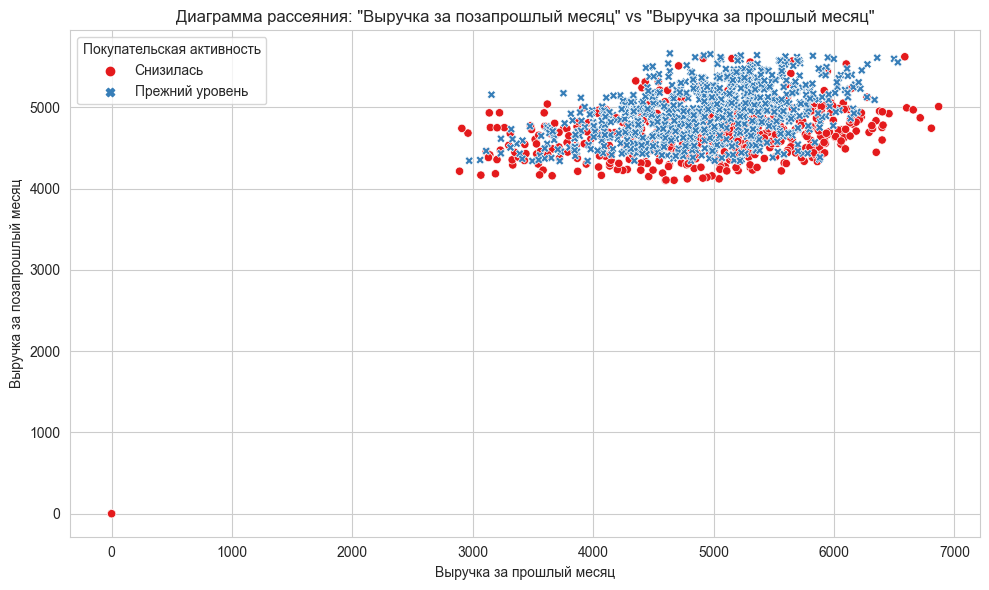

In [55]:
scatt_plot(feature1='revenue_last_month' , feature2='revenue_before_last_month')

**Выводы**

---

`Выручка за прошлый месяц` vs `Выручка за позапрошлый месяц`

Связь между доходами за позапрошлый и прошлый месяцы выражена гораздо слабее. Облако точек имеет более размытую, горизонтально-вытянутую форму. Корреляция есть, но она заметно ниже, чем на первом графике.

Группы точек имеют четкую границу для разделения

Для группы c типои Покупательской активности 'снизилась ' проходит по нижней границе облака, тогда как группа 'Прежний уровень' находиться почти полностью в верхней части графика

Можно предположить существование определенного  порога суммарного дохода от клиента за прошлый и позапрошлый месяц. Клиенты, чьи суммарные доходы за два месяца падают ниже этого порога, с высокой долей вероятности перейдут в категорию чья покупательская активность 'снизилась' в следующем месяце. Это позволит выделять группу риска.

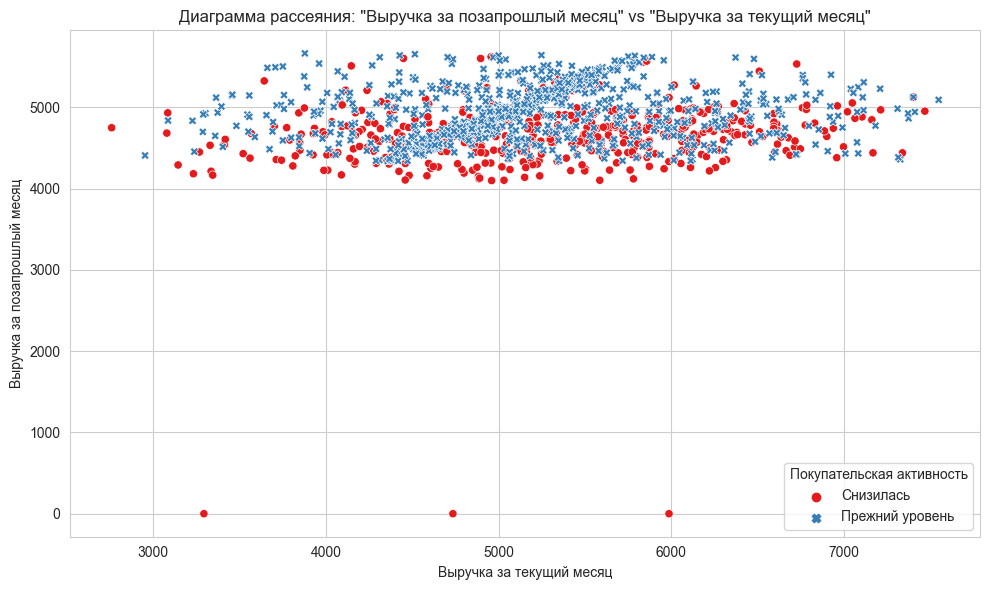

In [56]:
scatt_plot(feature1='revenue_cur_month' , feature2='revenue_before_last_month')

**Выводы**

`Выручка за прошлый месяц` vs `Выручка за позапрошлый месяц`

Связь между доходами за позапрошлый и текущий месяцы выражена минимально. 
Облако точек имеет беще более размытую, горизонтальную вытянутую форму. Корреляция незначительная

Группы точек имеют четкую границу для разделения

Для группы c типои Покупательской активности 'снизилась ' проходит по нижней границе облака, тогда как группа 'Прежний уровень' находиться почти полностью в верхней части графика

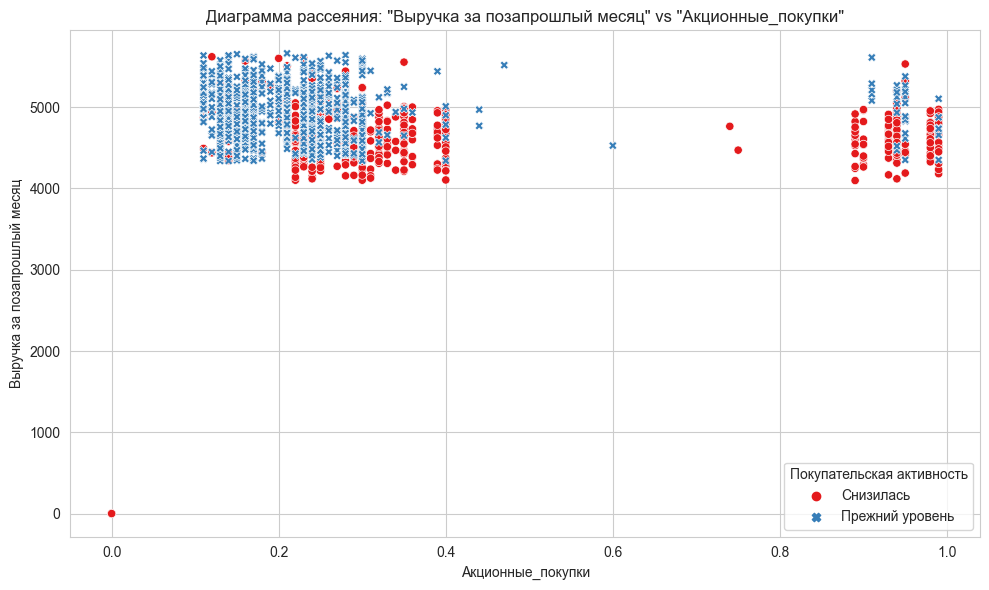

In [57]:
scatt_plot(feature1='promo_purchases' , feature2='revenue_before_last_month')

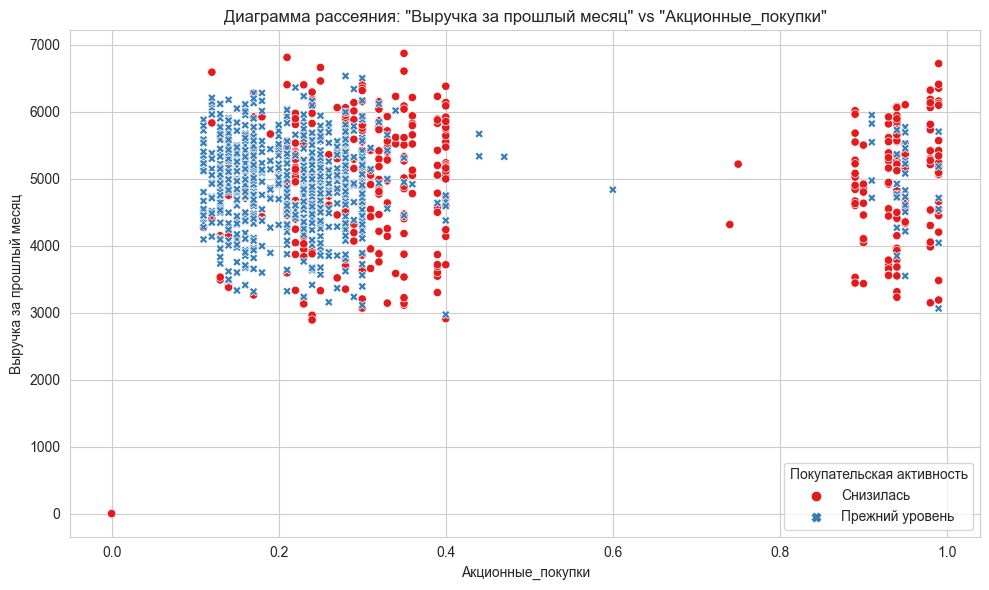

In [58]:
scatt_plot(feature1='promo_purchases' , feature2='revenue_last_month')

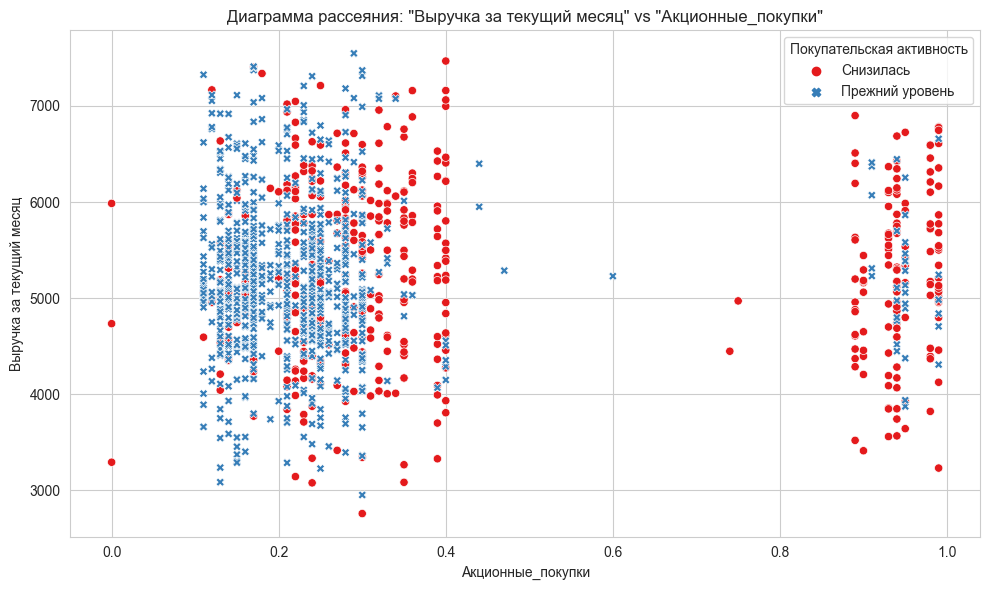

In [59]:
scatt_plot(feature1='promo_purchases' , feature2='revenue_cur_month')

**Выводы**

1. `Акционные_покупки` vs `Выручка за позапрошлый месяц`
2. `Акционные_покупки` vs `Выручка за прошлый месяц`
3. `Акционные_покупки` vs `Выручка за текущий месяц` 


Точки сгруппированы в вертикальные колонки, что говорит о дискретности переменной Акционные_покупки (promo_purchases)
линейная зависимость отсутствует.

так же можно заметить сто красные точки с типом покупательской активности 'снизилась' находяться в правой части графика, а синие в левой.

Акционные покупки в больинстве случаев позволяют увеличить выручку от клиентов которые стали менее активно приобретать товары на сайте. 

резделене на 2 четких облака может служить показателем наличия определенных клиентов, так называемых "охотников за скидками" — cherry pickers которые совершают исключительно акционные покупки.

особенно это заметно на правом облаке второго графика  где доля категории 'снизилась' заметно преобладает над клиентами прежнего уровня 



### Итоговое заключение по Корреляционному анализу

**Вовлечённость** — ключевой драйвер продаж. Наиболее сильными предикторами покупательской активности являются поведенческие метрики: **количество просмотренных страниц** (`Страниц_за_визит`) и **время проведенное на сайте за прошлый и текущий период** . Это прямо указывает на то, что глубина взаимодействия пользователя с сайтом напрямую влияет на покупки.

**Выручка прошлых периодов** — сильный, но избыточный фактор. Наблюдается очень сильная мультиколлинеарность между финансовыми показателями за разные месяцы (Выручка_за_позапрошлый_месяц, Выручка_за_прошлый_месяц). Их взаимная корреляция чрезвычайно высока (~0.73), что означает, что они несут практически идентичную информацию для модели. Использование всех этих признаков вместе не только не принесёт новой информации, но и навредит модели.

**Акционные покупки** имеют двойственную природу. С одной стороны, они демонстрируют стабильную корреляцию с общей выручкой, подтверждая их эффективность для стимулирования продаж. С другой стороны, визуальный анализ показывает сегмент клиентов ("охотники за скидками"), которые совершают покупки исключительно во время акций. Для таких клиентов высокая доля акционных покупок может быть не признаком лояльности, а, наоборот, индикатором риска снижения активности при отсутствии акций.

**Наличие порогового значения выручки** от "уходящих" клиентов. Взаимное распредеение выручки за прошлый и позапрошлый месяцы чётко разделяет клиентов с активностью снизилась и прежний уровень. Клиенты, чья суммарная выручка за два месяца падает ниже некоего порога, с высокой вероятностью переходят в категорию снизившейся активности. Это ценная информация для выделения группы риска.

Наличие "шумовых" признаков. Признак **Разрешить_сообщать** не показывает значимой корреляции ни с целевой переменной, ни с другими признаками. Он является статистическим шумом и не должен использоваться для прогнозирования.

---

**Для уменьшения переобучения модели** и повышения её эффективности рекомендуется удалить признак **Выручка_за_прошлый_месяц** по следующим причинам:
1. Высокая мультиколлинеарность между соседними финансовыми периодами:
  Как показал анализ, признаки Выручка_за_позапрошлый_месяц и Выручка за прошлый месяц сильно коррелируют (φk ≈ 0.73), так же как  Выручка за прошлый_месяц и Выручка за текущий месяц (φk ≈ 0.7). Модели машинного обучения, особенно линейные, очень чувствительны к такой ситуации.
2. Затрудняет интерпретацию: невозможно понять, какой из трех практически идентичных признаков на самом деле влияет на целевую переменную.
3. Повышает риск переобучения




## Пайплайны

In [60]:
def analyze_class_balance(y_train, y_test):
    """
    Функция для анализ дисбаланса целевой переменной
    """
 
    print('Анализ дисбаланса')
    print("=" * 60)
    
    train_counts = y_train.value_counts()
    test_counts = y_test.value_counts()
    
    print('Тренировочная выборка:')
    print(f"Общее количество: {len(y_train)}")
    for cls in train_counts.index:
        count = train_counts[cls]
        pct = (count / len(y_train)) * 100
        print(f"Класс '{cls}': {count} - ({pct:.2f}%)")
    
    print("\nТестовая выборка:")
    print(f"Общее количество: {len(y_test)}")
    for cls in test_counts.index:
        count = test_counts[cls]
        pct = (count / len(y_test)) * 100
        print(f"Класс '{cls}': {count} - ({pct:.2f}%)")
    
    return train_counts, test_counts

In [61]:
# Разделение выборки
drop_columns = ['id', 'revenue_last_month', 'promotional_consent']

X = market_all.drop(columns=drop_columns + ['customer_activity'])
y = market_all['customer_activity']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [62]:
# Кодирование целевой переменной
le = LabelEncoder()
y_train_encoded = pd.Series(le.fit_transform(y_train))
y_test_encoded = pd.Series(le.transform(y_test))

# Словарь соответствия кодов и меток 
encode_dict = dict(zip(le.classes_, range(len(le.classes_))))
# словарь для декодирования
decode_dict = dict(zip(range(len(le.classes_)), le.classes_))

print('Соответствие категорий и кодов:', encode_dict)
print('Словарь для декодирования:', decode_dict)

Соответствие категорий и кодов: {'Прежний уровень': 0, 'Снизилась': 1}
Словарь для декодирования: {0: 'Прежний уровень', 1: 'Снизилась'}


In [63]:
train_counts, test_counts = analyze_class_balance(y_train, y_test)

Анализ дисбаланса
Тренировочная выборка:
Общее количество: 1040
Класс 'Прежний уровень': 642 - (61.73%)
Класс 'Снизилась': 398 - (38.27%)

Тестовая выборка:
Общее количество: 260
Класс 'Прежний уровень': 160 - (61.54%)
Класс 'Снизилась': 100 - (38.46%)


**Выводы**

Дисбаланс 62/38 (класс 0 / класс 1) не является критическим, но он заметен, поэтому при проведении экспериментов с моделью будем использовать стратифицированную кросс-валидацию для корректной оценки производительности и выбора оптимальных параметров\
Но при этом можно использовать стандартные метрики без учета веса

### Выбор скелкров и кодировщиков для масштабирования и кодирпования данных
1. **Числовеые признаки**

Для параметров: 
  - `'avg_marketing_6month'`: 'Маркет_актив_6_мес',
  - `'promo_purchases'`: 'Акционные_покупки',
  - `'unpaid_products_count_3m'`: 'Неоплаченные_продукты_штук_квартал',
  - `'revenue_before_last_month'`: 'Выручка за позапрошлый месяц',
  - `'revenue_cur_month'`: 'Выручка за текущий месяц'
  
  Для данной группы будем использоваь MinMaxScaler так как признаки мимеют различное распредленеие и характеризуются пусть и незначительным но наличием выбросов.

Для параметров: 
  - `'account_age_days'`: 'Длительность',
  - `'avg_marketing_cur_month'`: 'Маркет_актив_тек_мес',
  - `'mean_categories_viewed_visit'`: 'Средний_просмотр_категорий_за_визит',
  - `'mean_pages_viewed_visit'`: 'Страниц_за_визит',
  - `'min_on_site_last_month'`: 'Время проведенное на сайте за прошлый месяц (мин)', 
  - `'min_on_site_cur_month'`: 'Время проведенное на сайте за текущий месяц (мин)'
  - `'service_error'`: 'Ошибка_сервиса'

Так как данные признаки имеют распределение, близкое к нормальному, и отсутствие выбросов, для масштабирования будем использованать StandardScaler.
Он преобразует данные к распределению с нулевым средним и единичной дисперсией

2. **Категориальные признаки**

- Признак `'service_type'` (`'Тип сервиса'`) Имеет бинарное значение и имеет явную порядковую природу так как 'премиум' подрузамевает под собой более высокий уровень сервиса\
  Для кодирования данного признака будем использовать OrdinalEncoder

- Признак `'primary_category'` (`'Популярная_категория'`)
Так как популярные категории товаров могут часто меняться, и не имеют какого либо естественного порядка дял кодирования данных этого параметра выберем OneHotEncoder
потому что одной из ключевых способностей данного кодировщика является возможность корректно обрабатывать новые категории, которые появятся в будущем - параметр `handle_unknown='ignore'` гарантирует, что модель не сломается при встрече с неизвестной категорией во время обучения, а проигнорирует её.


In [64]:
minmax_cols = [
    'avg_marketing_6month',
    'promo_purchases',
    'unpaid_products_count_3m',
    'revenue_before_last_month',
    'revenue_cur_month'
    ]


standard_cols = [
    'account_age_days',
    'avg_marketing_cur_month',
    'mean_categories_viewed_visit', 
    'mean_pages_viewed_visit',
    'min_on_site_last_month',
    'min_on_site_cur_month', 
    'service_error'
    ]

ohe_cols = ['primary_category']


ord_cols = ['service_type']
ord_cat=['стандарт', 'премиум']

In [65]:
standard_scaler_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='mean')), 
        ('scaler', StandardScaler()) 
    ]
)


min_max_scaler_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', MinMaxScaler()) 
    ]
)


ohe_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')),  
        ('ohe', OneHotEncoder(drop = 'first',handle_unknown='ignore', sparse_output=False))
    ]
)


ord_pipe = Pipeline(
    [
    ('imputer', SimpleImputer(strategy='most_frequent')),      
    ('ordinal_encoder', OrdinalEncoder(categories=[ord_cat], handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('min_max', min_max_scaler_pipe, minmax_cols),
        ('standard', standard_scaler_pipe, standard_cols),
        ('ohe', ohe_pipe, ohe_cols),
        ('ordinal', ord_pipe, ord_cols)
    ],
    remainder='passthrough'
)

In [66]:
pipelines_params = {
    'logistic_regression': {
        'pipeline': Pipeline([
            ('preprocessor', preprocessor),
            ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
        ]),
        'param_grid': {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear', 'saga']
        }
    },
    'decision_tree': {
        'pipeline': Pipeline([
            ('preprocessor', preprocessor),
            ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]),
        'param_grid': {
            'model__max_depth': [3, 5, 7, 10],
            'model__min_samples_leaf': [2, 5, 10]
        }
    },
    'knn': {
    'pipeline': Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier())
    ]),
    'param_grid': {
        'model__n_neighbors': [3, 5, 7, 9, 11],  # Количество соседей
        'model__leaf_size': [10, 20, 30],
        'model__p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
    }
},
    
    'svc': {
        'pipeline': Pipeline([
            ('preprocessor', preprocessor),
            # probability=True необходимо для расчета roc_auc_score
            ('model', SVC(random_state=RANDOM_STATE, probability=True))
        ]),
        'param_grid': [
            {
                'model__kernel': ['linear'],
                'model__C': [0.1, 1, 10]
            },
            {
                'model__kernel': ['rbf'],
                'model__C': [0.1, 1, 10],
                'model__gamma': ['scale', 'auto']
            }
        ]
    }
}


**Выбор метрики для подбора гиперпараметров**

Так как результатом нашей модели будет бинарная классификация, а данные не достаточно сбаллансированы (покупательская активность `снизилась`/`прежний уровень` 38%/62%) F1-score (macro) будет  оптимальным выбором метрики для оценки качества модели 


**Основные преимущества данной метрики:**
1. **Сбалансированная оценка:** \
 f1 - это гармоническое среднее между точностью (precision) и полнотой (recall), обеспечивает комплексный взгляд на качество модели.

2. **Универсальность применения:** \
 f1 эффективно работает в условиях неопределенности относительно стоимости ошибок первого (FP) и второго (FN) рода

3. **Устойчивость к дисбалансу:** \
 макроусреднение позволяет корректно оценивать качество классификации для каждого класса независимо от их распределения в данных.

In [67]:
# Стратифицированная кросс-валидация
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [68]:
best_model_estimator = None
best_model_score = -1
best_model_name = ''
all_results = {}


for model_name, params in pipelines_params.items():
    gs = GridSearchCV(
        estimator=params['pipeline'],
        param_grid=params['param_grid'],
        cv=stratified_cv,
        scoring='f1',
        n_jobs=-1
        #verbose=1
    )

    gs.fit(X_train, y_train_encoded)

    all_results[model_name] = {
        'best_score': gs.best_score_,
        'best_params': gs.best_params_,
    }
    
    print(f'Лучший F1-score на {model_name}: {gs.best_score_:.4f}')
    print(f'Лучшие параметры: {gs.best_params_}\n')

    # находим лучшую модель
    if gs.best_score_ > best_model_score:
        best_model_score = gs.best_score_
        best_model_pipe = gs.best_estimator_
        best_model_name = model_name
        best_params = gs.best_params_

Лучший F1-score на logistic_regression: 0.8249
Лучшие параметры: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Лучший F1-score на decision_tree: 0.8015
Лучшие параметры: {'model__max_depth': 3, 'model__min_samples_leaf': 2}

Лучший F1-score на knn: 0.8197
Лучшие параметры: {'model__leaf_size': 10, 'model__n_neighbors': 9, 'model__p': 1}

Лучший F1-score на svc: 0.8419
Лучшие параметры: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}



In [69]:
separator()
print('Результаты подбора модели и гиперпараметров')
print(f'Лучшая модель: {best_model_name.upper()}')
print(f'Параметры лучшей модели: {best_params}')
print(f'Лучший F1-score: {best_model_score:.4f}')

print("Полные результаты:")
for name, result in all_results.items():
    print(f"- {name}: {result['best_score']:.4f}")
separator()

Результаты подбора модели и гиперпараметров
Лучшая модель: SVC
Параметры лучшей модели: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Лучший F1-score: 0.8419
Полные результаты:
- logistic_regression: 0.8249
- decision_tree: 0.8015
- knn: 0.8197
- svc: 0.8419


In [70]:
print(best_model_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['avg_marketing_6month',
                                                   'promo_purchases',
                                                   'unpaid_products_count_3m',
                                                   'revenue_before_last_month',
                                                   'revenue_cur_month']),
                                                 ('standard',
                                                  Pipeline(step

In [71]:
# Предсказание и метрика
y_pred = best_model_pipe.predict(X_test)
f1_best_model = f1_score(y_test_encoded, y_pred)
print(f'F1-score на тестовой выборке: {f1_best_model:.4f}')

F1-score на тестовой выборке: 0.8324


**Выводы**

---

1. **Лучшая модель**: SVC с подобранными гиперпараметрами
        
2. **Метрика F1-score **: 0.8419 , что говорит о хорошем качестве модели
3. **Метрика F1-score на тестовой выборке**  0.8324

SVC показала наилучший результат: Модель на основе метода опорных векторов с RBF-ядром продемонстрировала лучшую способность определения уровня пользовательской активности.\
Выбранные параметры (C=10, gamma='auto', kernel='rbf') указывают на сбалансированную модель, не склонную к сильному переобучению или недообучению.

###  Сравнение модели с константной модделью DummyClassifier

In [72]:
# создаем константную модель
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_model.fit(X_train, y_train_encoded)

# предсказание на тестовых данных
y_pred_dummy = dummy_model.predict(X_test)


# оценка качества модели по метрике f1
dummy_f1 = f1_score(y_test_encoded, y_pred_dummy)

print(f'F1-score константной модели (DummyClassifier): {dummy_f1:.4f}')
print(f'F1-score нашей лучшей модели ({best_model_name}): {f1_score(y_test_encoded, y_pred):.4f}')
print(f'Разница метрик лучшей и константной модели {f1_best_model - dummy_f1:.4F}')

F1-score константной модели (DummyClassifier): 0.4400
F1-score нашей лучшей модели (svc): 0.8324
Разница метрик лучшей и константной модели 0.3924


**Выводы**

Модель прошла проверку на адекватность\
Разница метрик F1 между лучшей и константной моделью составляет 0,3924. Это означает что подобранная модель на 39.24% лучше определяет целевой параметр чем константная.

In [73]:
best_preprocessor = best_model_pipe.named_steps['preprocessor']
feature_names = best_preprocessor.get_feature_names_out()

feature_names

array(['min_max__avg_marketing_6month', 'min_max__promo_purchases',
       'min_max__unpaid_products_count_3m',
       'min_max__revenue_before_last_month', 'min_max__revenue_cur_month',
       'standard__account_age_days', 'standard__avg_marketing_cur_month',
       'standard__mean_categories_viewed_visit',
       'standard__mean_pages_viewed_visit',
       'standard__min_on_site_last_month',
       'standard__min_on_site_cur_month', 'standard__service_error',
       'ohe__primary_category_Косметика и аксесуары',
       'ohe__primary_category_Кухонная посуда',
       'ohe__primary_category_Мелкая бытовая техника и электроника',
       'ohe__primary_category_Техника для красоты и здоровья',
       'ohe__primary_category_Товары для детей', 'ordinal__service_type'],
      dtype=object)

In [74]:
def clean_feature_names(feature_names):
    """
    Убирает префиксы трансформеров из имен признаков
    """
    cleaned_names = []
    for name in feature_names:
        # Разделяем имя по двойному подчеркиванию
        if '__' in name:
            # Берем часть после последнего '__'
            cleaned_name = name.split('__')[-1]
            cleaned_names.append(cleaned_name)
        else:
            cleaned_names.append(name)
    return cleaned_names

In [75]:
feature_names = clean_feature_names(feature_names)

In [76]:
X_train_processed = pd.DataFrame(
    best_preprocessor.fit_transform(X_train),
    columns=feature_names
)

X_test_processed = pd.DataFrame(
    best_preprocessor.transform(X_test),
    columns=feature_names
)

best_model = best_model_pipe.named_steps['model']

In [77]:
result = permutation_importance(
    best_model, 
    X_test_processed, 
    y_test_encoded, 
    n_repeats=10, 
    random_state=RANDOM_STATE,
    scoring='f1',
    n_jobs=-1
)

In [78]:
feature_importance = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': result['importances_mean'],
    'Std': result['importances_std']
}).sort_values(by='Importance')

feature_importance.head()

,Feature,Importance,Std
6,avg_marketing_cur_month,-0.011583,0.008087
5,account_age_days,-0.003798,0.009306
17,service_type,-0.003775,0.003445
13,primary_category_Кухонная посуда,-0.002708,0.006051
11,service_error,-0.002498,0.007071


In [79]:
feature_importance['Feature'].unique().tolist()

['avg_marketing_cur_month',
 'account_age_days',
 'service_type',
 'primary_category_Кухонная посуда',
 'service_error',
 'primary_category_Товары для детей',
 'primary_category_Мелкая бытовая техника и электроника',
 'revenue_before_last_month',
 'revenue_cur_month',
 'mean_categories_viewed_visit',
 'primary_category_Техника для красоты и здоровья',
 'avg_marketing_6month',
 'primary_category_Косметика и аксесуары',
 'unpaid_products_count_3m',
 'promo_purchases',
 'min_on_site_last_month',
 'min_on_site_cur_month',
 'mean_pages_viewed_visit']

In [80]:
encoded_feature_names_primary_category = {

    'primary_category_Косметика и аксесуары' : 'Популярная_категория_Косметика и аксесуары',
    'primary_category_Кухонная посуда' : 'Популярная_категория_Кухонная посуда',
    'primary_category_Товары для детей' : 'Популярная_категория_Товары для детей',
    'primary_category_Мелкая бытовая техника и электроника' : 'Популярная_категория_Мелкая бытовая техника и электроника',
    'primary_category_Техника для красоты и здоровья' : 'Популярная_категория_Техника для красоты и здоровья'
}

original_feature_names = original_columns_market_all | encoded_feature_names_primary_category


In [81]:
# пеерименовываем параметры, используя безопасный способ получения данных из словаря при помощи метода get()

feature_importance['Feature'] = feature_importance['Feature'].apply(
    lambda x: original_feature_names.get(x, x)
)

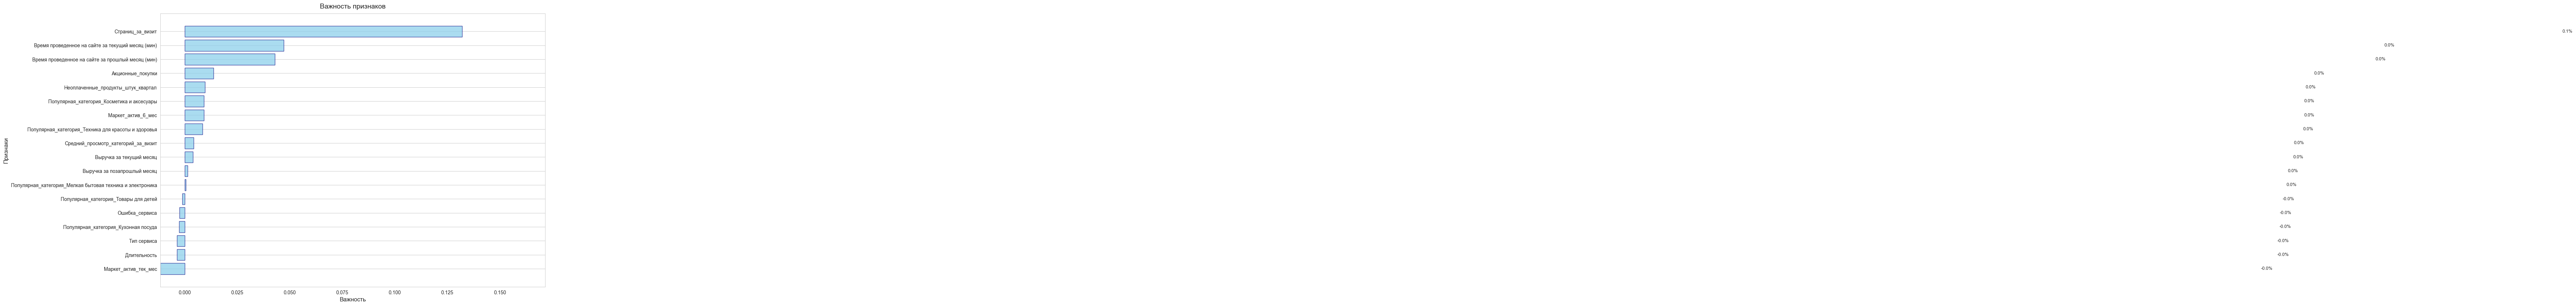

In [82]:
#Строим график с подписями
plt.figure(figsize=(14, 10))

bars = plt.barh(
    feature_importance['Feature'], 
    feature_importance['Importance'],
    color='skyblue',
    edgecolor='navy',
    alpha=0.7
)


# добавим значения на график
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(
        width + 1, 
        bar.get_y() + bar.get_height()/2, 
        f'{width:.1f}%',
        ha='left', 
        va='center',
        fontsize=9
    )

plt.title('Важность признаков', fontsize=14, pad=10)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.xticks(fontsize=10, wrap=True)
plt.yticks(fontsize=10, wrap=True)

# Настраиваем сетку
plt.grid(axis='x', alpha=0.2, linestyle='--')

plt.xlim(feature_importance['Importance'].min(), feature_importance['Importance'].max() * 1.3) 

plt.tight_layout()
plt.show()

**Выводы**

Можно заметить что **Тип сервиса** (`service_type`) и **Длительность** (`account_age_days`) не помогают, и скорее всего даже мешают в определении категории активности клиента

Создадим улучшеную версию модели без лишних параметров и проверим метрику

In [83]:
# Для KernelExplainer нужна функция, которая принимает на вход обработанные данные
# и возвращает вероятности класса 1
predict_proba_func = lambda x: best_model.predict_proba(x)[:, 1]

# Для простоты возьмем случайную подвыборку из обучающих данных
X_train_sample = shap.sample(X_train_processed, 100)

explainer = shap.KernelExplainer(predict_proba_func, X_train_sample)
shap_values = explainer.shap_values(X_test_processed)

  0%|          | 0/260 [00:00<?, ?it/s]

In [84]:
rus_feature_names = [original_feature_names[feature] for feature in feature_names]

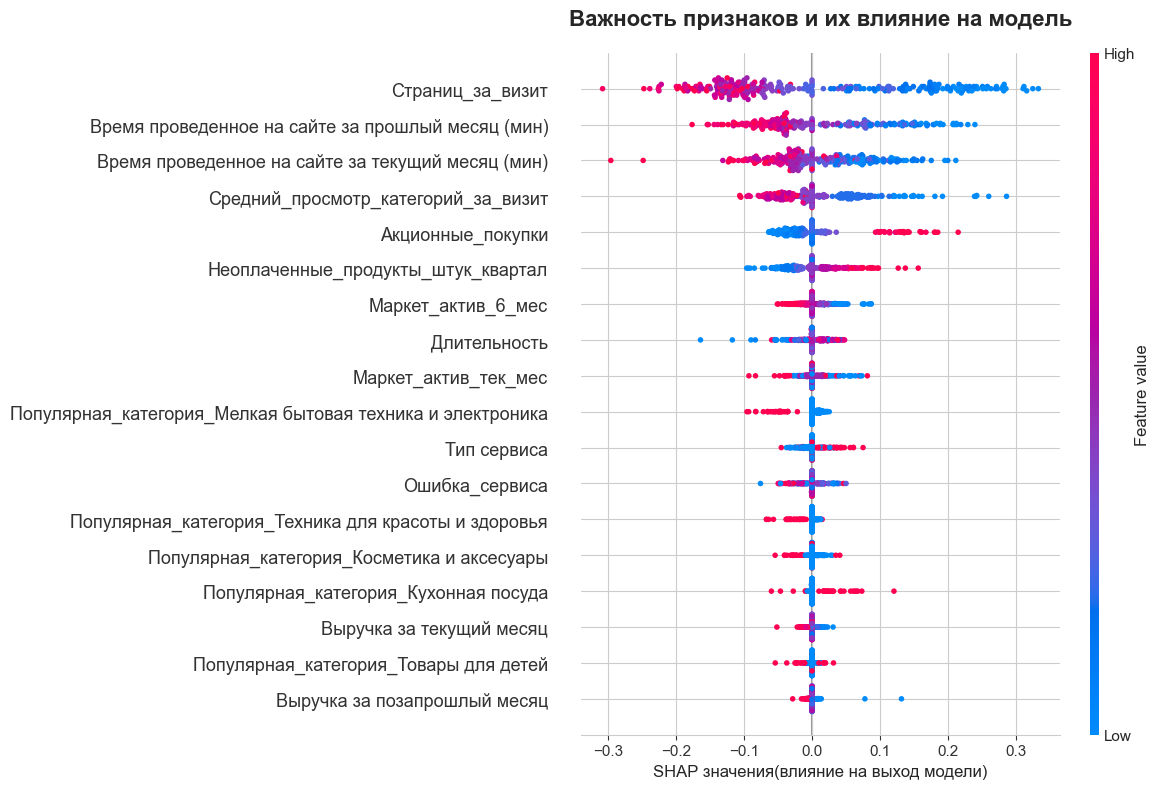

In [85]:
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test_processed, 
                  feature_names=rus_feature_names,
                  plot_size=(12, 8),
                  show=False)

plt.title('Важность признаков и их влияние на модель', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('SHAP значения(влияние на выход модели)', fontsize=12)
plt.tight_layout()
plt.show()

**Выводы по графику summary_plot**


**Топ-5 самых влиятельных признаков, определяющих отток:**

- **Страниц_за_визит** - `mean_pages_viewed_visit` (Среднее количество просмотренных страниц за визит)
- **Время проведенное на сайте за прошлый месяц (мин)** - `min_on_site_last_month`
- **Средний_просмотр_категорий_за_визит** - `mean_categories_viewed_visit` (Среднее количество просмотренных категорий за визит)
- **Время проведенное на сайте за текущий месяц (мин)** - `min_on_site_cur_month`
- **Акционные_покупки** - `promo_purchases` (доля покупок по промоакциям)

**Как признаки влияют на прогноз:**

Высокие значения признаков (красные точки слева) `Страниц_за_визит`, `Время проведенное на сайте за прошлый месяц (мин)`, `Средний_просмотр_категорий_за_визит`, `Время проведенное на сайте за текущий месяц (мин)`  снижают вероятность оттока. Это логично: чем активнее и глубже пользователь изучает сайт, тем он более вовлечен и лоялен.
Низкие значения этих же признаков (синие точки справа) сильно повышают вероятность оттока. Падение активности — главный предвестник ухода клиента.

Высокие значения признака `Акционные_покупки` (красные точки справа) повышают вероятность оттока. Это нелогичный, но очень важный инсайт. Вероятно, это сегмент "охотников за скидками", которые нелояльны бренду и уходят, как только заканчиваются выгодные предложения. Или это клиенты, которых магазин "перекормили" акциями, и теперь они не готовы покупать по полной цене.

Низкие значения признака `Неоплаченные_продукты_штук_квартал` снижают вероятность оттока, а высокие — повышают. Это классический пример "брошенной корзины".

In [86]:
# Создадим `Explanation` для более удобной работы
shap_explanation = shap.Explanation(values=shap_values,
                                    base_values=explainer.expected_value,
                                    data=X_test_processed,
                                    feature_names=rus_feature_names,
                                    )


In [87]:
def custom_waterfall_plot(shap_explanation, idx, max_display=15, figsize=(14, 10)):
    """
    Улучшенный waterfall plot с кастомизацией для лучшей читаемости
    """
    
    explanation = shap_explanation[idx]
    
    # Создаем фигуру с настроенным размером
    plt.figure(figsize=figsize)
    
    # Создаем waterfall plot со стандартными цветами SHAP
    shap.plots.waterfall(explanation, max_display=max_display, show=False)
    
    # Получаем текущие оси
    ax = plt.gca()
    
    # Улучшаем заголовок
    ax.set_title(f'Детальный анализ предсказания модели (Пример №{idx})', 
                 fontsize=18, fontweight='bold', pad=30)
    
    # Улучшаем подписи осей
    ax.set_xlabel('Вклад в предсказание (SHAP значения)', 
                  fontsize=13, fontweight='bold', labelpad=15)
    
 
    # Улучшаем сетку
    ax.grid(True, alpha=0.2, axis='x', linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)  # Сетка позади данных
    

    
    # Вычисляем значения для информационной панели
    base_value = explanation.base_values
    final_value = base_value + explanation.values.sum()
    total_impact = explanation.values.sum()
    
    # Создаем улучшенную информационную панель
    info_text = (f'• Базовое значение (среднее по выборке): {base_value:.4f}\n'
                 f'• Общее влияние признаков: {total_impact:+.4f}\n'
                 f'• Итоговое предсказание: {final_value:.4f}')
    
    plt.figtext(0.12, -0.005, info_text, fontsize=11, verticalalignment='bottom')
    
    # Добавляем горизонтальную линию для нулевого значения
    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
    
    plt.show()

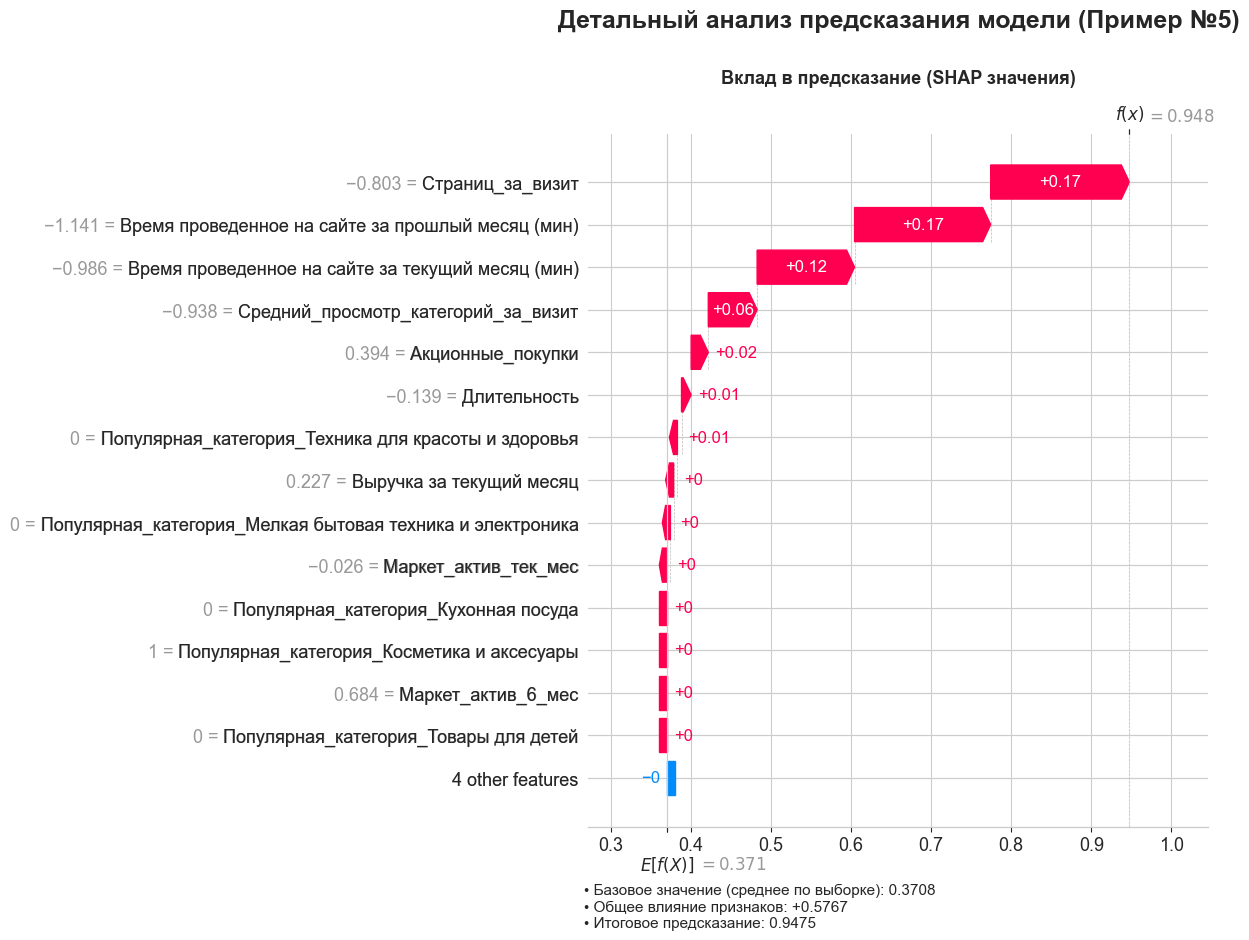

In [88]:
custom_waterfall_plot(shap_explanation, 5)

**Выводы по вграфику Waterfall Plot для клиента с индексом 5**\
Этот график прекрасно объясняет, почему модель считает, что клиент с индексом `5` уйдет с вероятностью 94.75%

Базовая вероятность оттока (средняя по всем клиентам) составляет `E[f(X)] = 0.3708` или 37,08%.
Далее мы видим, как каждый признак "двигает" эту вероятность вверх или вниз.\
**Ключевые факторы, повышающие риск оттока (красные стрелки):**
   - `Страниц_за_визит` = -0.803: Он просматривал очень мало страниц за визит. Это говорит о низкой вовлеченности (+0.18 к риску).
   - `Время проведенное на сайте за прошлый месяц (мин)` = -1.141: Клиент провел на сайте в прошлом месяце значительно меньше времени, чем в среднем. Это самый сильный негативный сигнал (+0.17 к риску).
 
   - `Время проведенное на сайте за текущий месяц (мин)` = -0.986: Его активность в текущем месяце также крайне низкая (+0.13 к риску).
   - `Средний_просмотр_категорий_за_визит` = -0.938: сократилось изучение количества категорий товаров (+0.06 к риску).

**Слабые факторы, снижающие риск (синяя стрелка):**
- `Неоплаченные_продукты_штук_квартал` = 0.1: У клиента мало брошенных корзин, что является небольшим позитивным сигналом (-0.03 от риска).

**В итоге** модель видит резкое падение поведенческой активности клиента (время на сайте, глубина просмотра) и, несмотря на отсутствие брошенных корзин, делает уверенный вывод о его скором уходе.

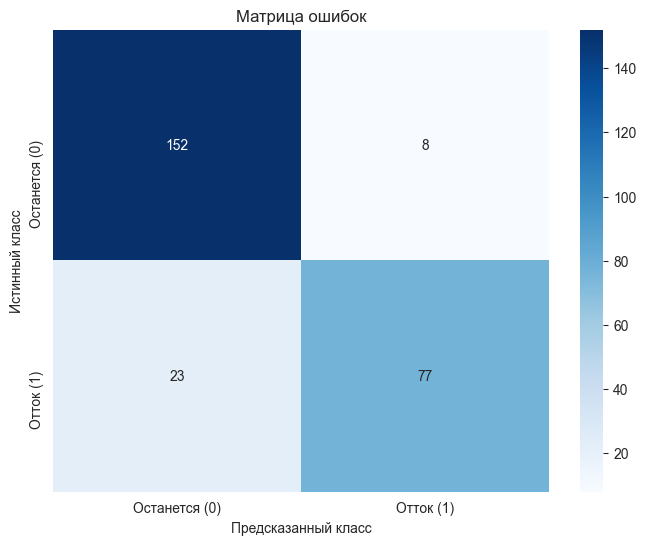

Количество пойманных клиентов с классом "Снизилась": 77
Количество пропущенных клиентов с классом "Снизилась": 23

Метрики:
Accuracy: 0.8808
Precision (для класса "Снизилась"): 0.9059
Recall (для класса "Снизилась"): 0.7700
F1-score (для класса "Снизилась"): 0.8324


In [89]:
cm = confusion_matrix(y_test_encoded, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Останется (0)', 'Отток (1)'], 
            yticklabels=['Останется (0)', 'Отток (1)'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

tn, fp, fn, tp = cm.ravel()
# Общий размер выборки
total = tn + fp + fn + tp

# Вывод количества пойманных и пропущенных оттоков
#tp = cm[1, 1]  # Истинно положительные (пойманные оттоки)
#fn = cm[1, 0]  # Ложно отрицательные (пропущенные оттоки)
print(f'Количество пойманных клиентов с классом "Снизилась": {tp}')
print(f'Количество пропущенных клиентов с классом "Снизилась": {fn}')


# Расчет метрик
accuracy = (tn + tp) / total  # Общая точность
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Точность для класса 1
recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Полнота для класса 1
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0  # F1 для класса 1

# Вывод результатов
print('\nМетрики:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (для класса "Снизилась"): {precision:.4f}')
print(f'Recall (для класса "Снизилась"): {recall:.4f}')
print(f'F1-score (для класса "Снизилась"): {f1:.4f}')

**Вывод по матрице ошибок**

---

Модель демонстрирует хорошую общую производительность (accuracy 88%), с высокой precision (90.5%), что минимизирует ложные тревоги и ненужные расходы на retention-кампании. Однако recall 77% указывает на проблему: 23 клиент с категорией "снизилась" пропущен, что может привести к потере этих клиентов. F1-score 0.8324 подтверждает баланс, но в задаче класификации оттока клиентов приоритет будет у метрики recall, так как стоимость пропущенного клиента который находиться на грани ухода выше, чем перерасход на удержание лояльности. 

**Предложения по улучшению модели**

**Балансировка классов:** Использовать техники oversampling вроде SMOTE  для класса 'Снизилась' или class_weight='balanced' в SVC. Это повысит recall без сильного снижения precision.

**Тюнинг гиперпараметров:**\
Провести новый поиск модели через GridSearchCV для SVC с новой метрикой, учитываюей recall, например.
```python
def custom_f1_recall_scorer(y_true, y_pred):
    # Вычисляем Recall
    recall = recall_score(y_true, y_pred)
    
    # Если Recall ниже порога, возвращаем очень низкое значение, например 0
    if recall < 0.9:
        return 0  
    
    # Если условие выполнено, возвращаем F1-score
    return f1_score(y_true, y_pred)```

### Итоговые выводы по ананлизу важности признаков

---

На основе предтавленных графиков можно сделать вывод:

1. **Малозначимые признаки:**

Малозначимыми оказались признаки, расположенные в нижней части графика Summary Plot. Их влияние на итоговое предсказание модели близко к нулю.\

 - `revenue_cur_month` - 'выручка в текущем месяце'
 - `primary_category_Кухонная посуда` - 'Популярная_категория_Кухонная посуда'
 - `primary_category_Товары для детей`'Популярная_категория_Товары для детей'
 - `primary_category_Косметика и аксессуары`'Популярная_категория_Косметика и аксессуары'
 - `avg_marketing_cur_month` - 'Маркет_актив_тек_мес'

Это означает, что ни недавняя сумма покупок, ни принадлежность клиента к этим конкретным категориям практически не влияют на его склонность к оттоку в данной модели.


2. **Наиболее важные признаки**

Сильнее всего влияют признаки, находящиеся вверху Summary Plot, которые демонстрируют наибольший разброс SHAP-значений. Ключевое влияние оказывают поведенческие метрики и реакция на промоакции.

**Поведенческая активность:**

 - `mean_pages_viewed_visit` -  'Страниц_за_визит'
 - `min_on_site_last_month` 'минут на сайте в прошлом месяце'
 - `mean_categories_viewed_visit` - 'Средний_просмотр_категорий_за_визит'
 - `min_on_site_cur_month` 'минут на сайте в текущем месяце'

Низкие значения этих признаков (низкая активность и вовлеченность) резко повышают вероятность оттока. И наоборот, клиенты, которые проводят много времени на сайте и активно просматривают страницы и категории, с высокой вероятностью останутся лояльными.

**Покупки по акциям:**

 - `promo_purchases` 'Акционные_покупки'

Оказывает нелогичное влияние. Высокое значение этого признака (много покупок по акциям) повышает вероятность оттока. Это указывает на сегмент "охотников за скидками", которые нелояльны бренду и уходят, как только заканчиваются выгодные предложения.


3. **Как можно использовать эти наблюдения?**

**При моделировании:**

Малозначимые признаки можно рассмотреть для удаления из модели. Это упростит модель, ускорит её обучение и может даже повысить качество за счёт уменьшения "шума".

Так как поведение клиентов имеет решающее значение, можно создать новые признак, например разницу времени проведенного на сайте в текущем и прошлом месяце (за аналогичный период прошлого месяца) (min_on_site_cur_month - min_on_site_last_month) который будет отражать изменение активности клиентов. Сильное падение этого показателя станет хорошим сигналом для модели.

При принятии бизнес-решений:
Бизнес должен в первую очередь отслеживать вовлеченность и поведение пользователей. Падение времени на сайте или глубины просмотра — это главный фактор, который должен запускать механизмы возврата.

Настроить автоматические рекламные кампании (email, push-уведомления) для клиентов, чьи поведенческие метрики начинают падать чтобы вернуть их интерес персональными предложениями или напоминаниями.

Пересмотреть маркетинговые стратегии. Например вместо массовых скидок, которые привлекают "охотников", возможно стоит сфокусироваться на программе лояльности. Нужно поощрять постоянных клиентов (например промокодами на любимые категории товаров) а таак же стимулировать повторные покупки без скидок, а для "охотников за скидками" разработать отдельную стратегию, понимая риски их ухода.

**Важный инсайт:** Даже клиенты с высокой выручкой в текущем или позапрошлом месяце могут уйти, если их вовлеченность падает. Нельзя считать их лояльными по умолчанию — за их активностью нужно так же следить.


## Сегментация покупателей

In [90]:

data = market_all.copy().drop(['customer_activity'], axis=1)

# вероятности для всего датасета
activ_probability = best_model_pipe.predict_proba(X)[:,1]
data['activ_probability'] = activ_probability

data = data.merge(money, on='id', how='left')
data.head()

,id,service_type,promotional_consent,avg_marketing_6month,avg_marketing_cur_month,account_age_days,promo_purchases,primary_category,mean_categories_viewed_visit,unpaid_products_count_3m,service_error,mean_pages_viewed_visit,revenue_last_month,revenue_before_last_month,revenue_cur_month,min_on_site_last_month,min_on_site_cur_month,activ_probability,avg_profit_last_3m
0,215348,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.052178,0.98
1,215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.971739,4.16
2,215350,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.507964,3.13
3,215351,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.846736,4.87
4,215352,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.989733,4.21


In [91]:
# Сегментация клиентов

profit_median = data['avg_profit_last_3m'].median()

def get_segment(row, activ_threshold=0.5):
    if row['activ_probability'] > activ_threshold and row['avg_profit_last_3m'] > profit_median:
        return 'Высокий риск, высокая прибыль'
    elif row['activ_probability'] > activ_threshold and row['avg_profit_last_3m'] <= profit_median:
        return 'Высокий риск, низкая прибыль'
    elif row['activ_probability'] <= activ_threshold and row['avg_profit_last_3m'] > profit_median:
        return 'Низкий риск риск, высокая прибыль'
    else:
        return 'Низкий риск, низкая прибыль'

In [92]:
data['segment'] = data.apply(get_segment, axis=1)
# Распределение по сегментам
print(data['segment'].value_counts())

Низкий риск риск, высокая прибыль    445
Низкий риск, низкая прибыль          440
Высокий риск, низкая прибыль         210
Высокий риск, высокая прибыль        205
Name: segment, dtype: int64


### Анализ группы клиентов с высоким риском ухода и высокой прибылью

Данная группа клиентов критически важна для бизнеса, так как их отток напрямую влияет на значительную часть выручки. Несмотря на повышенную вероятность ухода, эти клиенты обладают наибольшим потенциалом для сохранения благодаря:
 - Персонализированным программам лояльности
 - Точечным мерам (например, эксклюзивные предложения)
 - Анализу триггеров их неудовлетворённости

In [93]:
priority_segment_mask = data['segment'] == 'Высокий риск, высокая прибыль'
priority_segment = data[priority_segment_mask]

# Аналитическая статистика по ключевым признакам (из SHAP)
key_features = ['mean_pages_viewed_visit', 'min_on_site_last_month', 'mean_categories_viewed_visit', 'min_on_site_cur_month', 'promo_purchases', 'avg_profit_last_3m', 'activ_probability']

priority_segment[key_features].describe()


,mean_pages_viewed_visit,min_on_site_last_month,mean_categories_viewed_visit,min_on_site_cur_month,promo_purchases,avg_profit_last_3m,activ_probability
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,4.370732,10.097561,2.429268,10.156098,0.481902,4.754976,0.927921
std,2.277150,2.788324,1.125080,2.875697,0.306008,0.576814,0.100137
min,1.000000,5.000000,1.000000,4.000000,0.000000,4.050000,0.518530
25%,3.000000,8.000000,2.000000,8.000000,0.250000,4.300000,0.892032
50%,4.000000,10.000000,2.000000,10.000000,0.320000,4.640000,0.971739
75%,6.000000,12.000000,3.000000,12.000000,0.900000,5.040000,0.994375
max,17.000000,23.000000,6.000000,21.000000,0.990000,7.430000,1.000000


In [94]:
data[~priority_segment_mask][key_features].describe()

,mean_pages_viewed_visit,min_on_site_last_month,mean_categories_viewed_visit,min_on_site_cur_month,promo_purchases,avg_profit_last_3m,activ_probability
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,8.889498,14.098630,3.427397,13.775342,0.289461,3.854658,0.277230
std,3.821142,3.792293,1.337129,4.188294,0.225415,1.014996,0.324843
min,1.000000,5.000000,1.000000,4.000000,0.000000,0.860000,0.011029
25%,6.000000,11.000000,2.000000,11.000000,0.160000,3.160000,0.071283
50%,9.000000,14.000000,3.000000,14.000000,0.230000,3.830000,0.145653
75%,11.500000,17.000000,4.000000,17.000000,0.290000,4.545000,0.267906
max,20.000000,23.000000,6.000000,23.000000,0.990000,7.210000,1.000000


In [95]:
original_columns_market_all

{'id': 'id',
 'customer_activity': 'Покупательская активность',
 'service_type': 'Тип сервиса',
 'promotional_consent': 'Разрешить сообщать',
 'avg_marketing_6month': 'Маркет_актив_6_мес',
 'avg_marketing_cur_month': 'Маркет_актив_тек_мес',
 'account_age_days': 'Длительность',
 'promo_purchases': 'Акционные_покупки',
 'primary_category': 'Популярная_категория',
 'mean_categories_viewed_visit': 'Средний_просмотр_категорий_за_визит',
 'unpaid_products_count_3m': 'Неоплаченные_продукты_штук_квартал',
 'service_error': 'Ошибка_сервиса',
 'mean_pages_viewed_visit': 'Страниц_за_визит',
 'revenue_last_month': 'Выручка за прошлый месяц',
 'revenue_before_last_month': 'Выручка за позапрошлый месяц',
 'revenue_cur_month': 'Выручка за текущий месяц',
 'min_on_site_last_month': 'Время проведенное на сайте за прошлый месяц (мин)',
 'min_on_site_cur_month': 'Время проведенное на сайте за текущий месяц (мин)'}

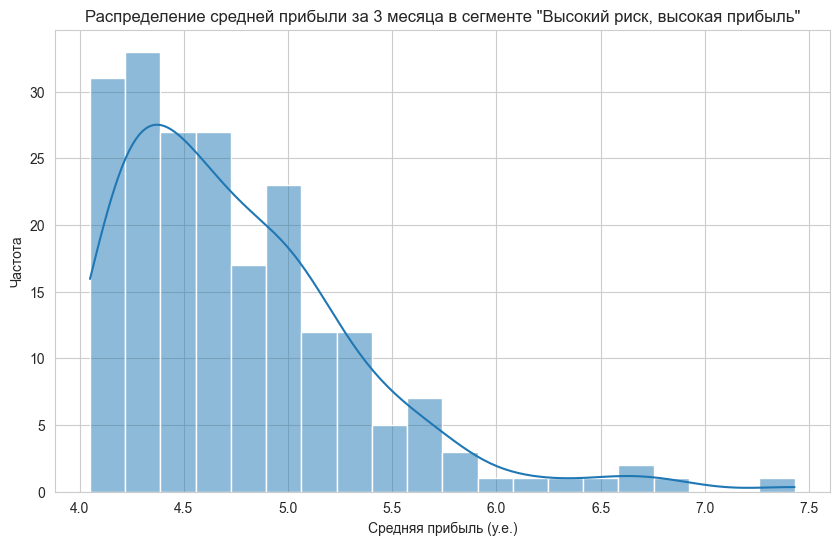

In [96]:
# График 1: Распределение прибыли
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(priority_segment['avg_profit_last_3m'], bins=20, kde=True)
plt.title('Распределение средней прибыли за 3 месяца в сегменте "Высокий риск, высокая прибыль"')
plt.xlabel('Средняя прибыль (у.е.)')
plt.ylabel('Частота')
plt.show()

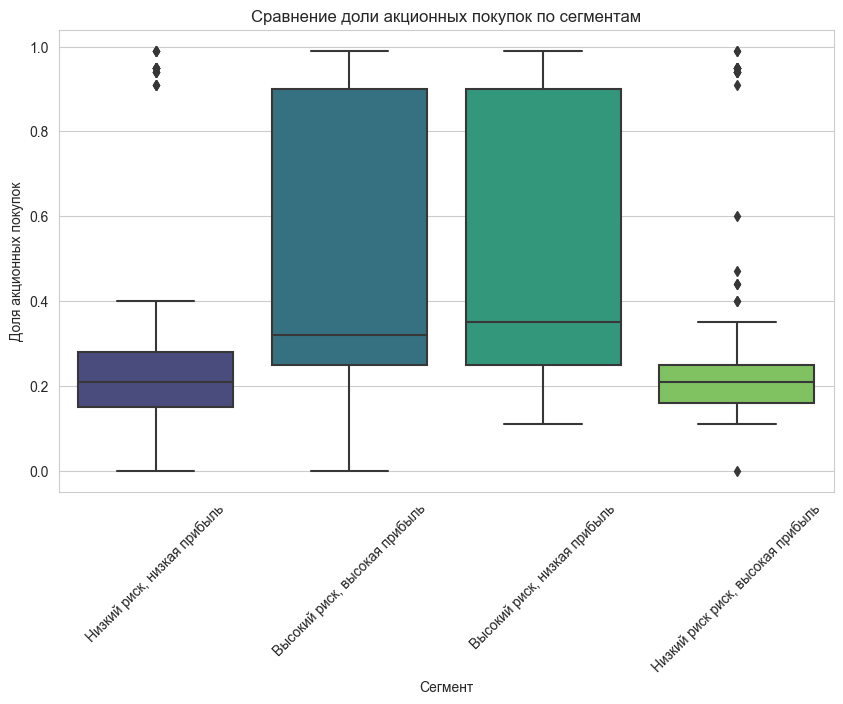

In [97]:
plt.figure(figsize=(10, 6))

# Строим боксплот
boxplot = sns.boxplot(
    x='segment', 
    y='promo_purchases', 
    data=data,
    palette="viridis" 
)

plt.xticks(rotation=45)
plt.title('Сравнение доли акционных покупок по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Доля акционных покупок')

plt.show()


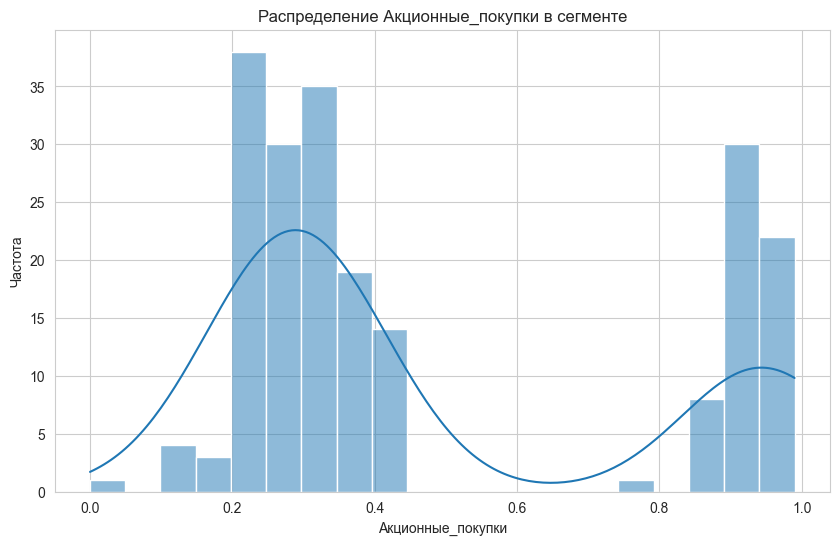

In [98]:
# Распределение акционных покупок в сегменте (с оригинальным названием)
plt.figure(figsize=(10, 6))
sns.histplot(priority_segment['promo_purchases'], bins=20, kde=True)
plt.title('Распределение Акционные_покупки в сегменте')
plt.xlabel('Акционные_покупки')
plt.ylabel('Частота')
plt.show()

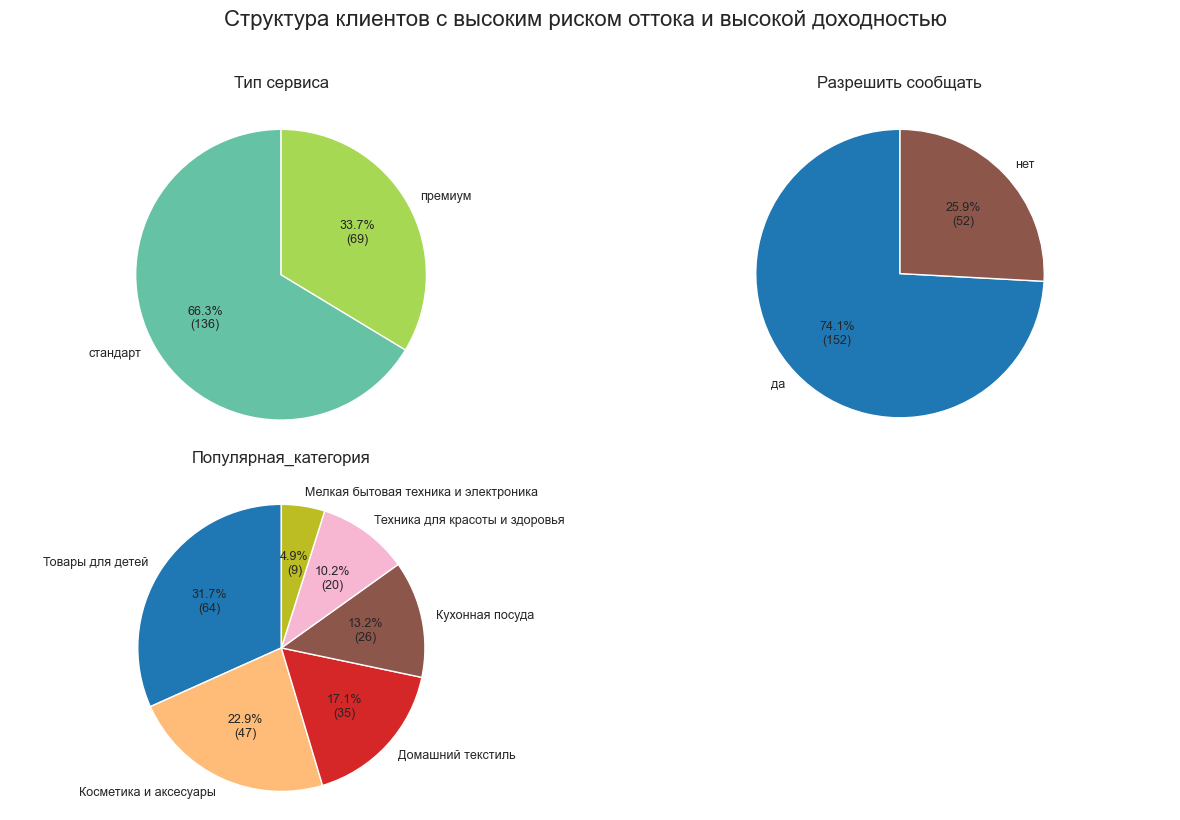

In [99]:
data_to_plot = [
    {
        'series': priority_segment['service_type'].value_counts(), 
        'title': original_columns_market_file['service_type'], 
        'color_map': 'Set2'
        },
    {
        'series': priority_segment['promotional_consent'].value_counts(), 
        'title': original_columns_market_file['promotional_consent'], 
        'color_map': 'Set4'
        },
    {
        'series': priority_segment['primary_category'].value_counts(), 
        'title': original_columns_market_file['primary_category'], 
        'color_map': 'tab20'
        }
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Построение диаграмм
for i, data in enumerate(data_to_plot):
    if i < len(axes):
        create_pie_chart(axes[i], 
                         data['series'].values, data['series'].index, 
                         data['title'], data['color_map'])

# Скрытие неиспользуемых осей
for ax in axes[len(data_to_plot):]:
    ax.axis('off')

plt.suptitle('Структура клиентов с высоким риском оттока и высокой доходностью', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



**Выводы по анализу сегменты клиентов с высоким риском унижения активности (оттоком) и высоким доходом**

---

**Изсходя из данных описательной статистики:**
 - Среднее значение вероятности снижения активности (оттока) в данном сегменте  91,75%  что подтверждает критический уровень риска ухода клиентов.
 - Медианная прибыль данной категории клиентов за последние 3 месяца - 4.645 у.е. (что значительно выше медианного значения прибыли остальной части клиентов - 3.825 у.е.) 
 - Низкие значения в ключевых категориях по сравнению с остальной частью клиентов 
 

| Параметр | Приоритетный сегмент | Остальные клиенты |
|:---|:---:|:---:|
| Среднее количество просмотренных 'Страниц_за_визит' | 4 | 9 |
| 'Время проведенное на сайте за прошлый месяц (мин)' | 10 | 14 |
| Средний_просмотр_категорий_за_визит |2|3|

что указывает на снижение вовлеченности данной категории клиентов.


Медианная доля акционных покупок выше чем у остальной категории клиентов (32% vs 23%)  что совпадает с выводами анализа важности признаков, (высокая доля акционных покупок, увеличивает вероятность снижения активности клиента)


**Графики показывают:**

 - Прибыль сконцентрирована в диапазоне 4-6 у.е., с пиком на 4,4
 - Ящик с усами показывает что в даной категории разброс значенний гораздо шире и средее значение гораздо больше, чем категории с низким риском, где высокие значения акционных покупок являются скорее аномалией чем правилом.
 - График распределения акционных покупок четко выделяет 2 сегмента покупателей - обычных клиентов с долей акционных покупок до 60%  с пиком на уровне 30% и "охотников за скидками" со значением доли акционных покупок от  70% и выше с пиком на уровне 90-100%
 - В то же время видно что доля елиентов с премиальным типом сервиса в данной категории составляет не более 33 %
 - Ключевые категории в которых совершаются покупки данным типом клиентов являются Товары для детей, косметика и домашний текстиль. Промо акции с данными категориями товаров можно использовать для поддержания интереса и лояльности клиентов этой категории.


**Предложения по работе с приоритетным сегментом для увеличения покупательской активности**

Персонализированные маркетинговые кампании: Используя данные о `Популярной категории` товаров, отправлять электронные письма и Push уведосления с акциями (например, скидки на "Товары для детей") для клиентов с долей акционных покупок 40% и менее.

Программы лояльности: Ввести баллы за время на сайте и просмотры категорий, чтобы поднять `Время проведенное на сайте` и количество просмотров `старниц за визит` и `Средний_просмотр_категорий_за_визит`. Предоставить данной категории клиентов  тип сервиса `премиум` с эксклюзивными предложениями.

Делать напоминания о брошенных корзинах для клиентов с высоким значением в категории Неоплаченные_продукты_штук_квартал — автоматические push с скидками, чтобы снизить неоплаченные продукты и увеличить выручку.

## Заключение

---

В нашем исследовании было необходимо:
1. Построить модель, предсказывающую вероятность снижения покупательской активности в 
следующие три месяца.  
2. Проанализировать данные о коммуникациях, продуктовом и покупательском поведении, а 
также поведении на сайте.  
3. Выделить сегменты клиентов на основе модели и данных о прибыльности, предложить 
стратегии повышения активности.  
4. Оценить важность признаков и дать рекомендации для бизнеса.


**Исходные данные и предобработка**

Данные были загружены с проверкой нескольких путей расположения файлов, корректным разделитиелем данных и корректным определеним числовых значений, что в дальнейшем исключило необходимость в преобразовании типов данных в числовых 
столбцах.

Были устранены неявные дубликаты и ошибки в категориальных данных (например, "стандартт" исправлено на "стандарт")

Проведен анализ выбросов в данных о выручке, и одно экстремальное значение было корректно заменено медианным.

Проведена фильтрация клиентов с активностью не менее 3 месяцев

Проведено корректное объединений данных трех таблиц
    - преобразованы столбцы в таблицах market_money и merket_time при помощи методов pivot_table
    - проведено объединение данных из вышеуказанных таблиц с таблицей market_file методом merge()

так же был проведен  корреляционный анализ на основании которого для дальнейшего построения модели был удален один признак не оказывающий влияния как на целевую переменную так и на остальные признаки (`Разрешить сообщать`). А так же признак с мультиколлинеарностью (`выручка за прошлый период`)

**Поиск лучшей модели**

Для поиска модели определяющей вероятность сниежения покупательской активности были определены параметры для масштабирования при помощи StandardScaler и MinMaxScaler а так же кодирования при помощи OneHotEncoder и OrdinalEncoder, построены пайплайны для масштабирования и кодирования данных из которых был собран препроцессор

Определена метрика для поиска лучшей модели (f1 mcro) так как результатом модели должна быть бинарная классификация  а данные целевой переменной недостаточно сбалансированы (покупательская активность `снизилась`/`прежний уровень` 38%/62%)

Подбор модели и её гиперпараметров был осуществлен при помощи GridSearchCV с применением стратифицированной кросс-валидации StratifiedKFold:

- Созданы сетки  моделей и возможных значений параметров
- Обучены модели на каждой комбинации параметров
- получена оценка качества модели на каждой комбинации модели и параметровОптимальная  - модель выбрана по наилучшему результату метрики
- Оптимальная модель выбрана по наилучшему результату метрики

Результаты подбора модели и гиперпараметров
Лучшая модель: SVC
Параметры лучшей модели: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Лучший F1-score: 0.8838
F1-score (macro) на тестовой выборке: 0.8495

Полные результаты:
- logistic_regression: 0.8640
- decision_tree: 0.8493
- knn: 0.8647
- svc: 0.8838


**Анализ признаков**

Проведен предварительный анализ признаков при помощи permutation_importance 
по итогам которого были убраны еще 2 признака не оказваающие влияния на модель
`Тип сервиса` и `Длительность` (возораст аккаунта в днях)
после чего была построен пайплайн с оптимальным выбором модели и параметров и проведено обучение модели без лишних признаков

после чего F1-score (macro) на тестовой выборке составил 0.8587, что незначительно но все же улучшило показатели модели

В дальнейшем был проведен подробный анализ важности признаков SHAP
построены графики summary_plot который помог понять, как именно модель машинного обучения принимает решения. На основании чего были выделены топ 5 признаков оказвающих значительное влияние на принятие решения

Рассмотрен вариант принятия решения дл клиента с индексом 5. Построен график waterfall, который так же подтвердил влияние и направленность признаков для принятия решения моделью.

Так же была помтроена матрица ошибок, из которой стало понятно что модель пропускает часть потенциально уходящих клиентов. В качестве улучшения модели предложен вариант с выбором кастомной метрики на основе максимального Recall и f1 макро

**Сегментация покупателей**

проведена сегментация покупателей на 4 категории 
 - Высокий риск, высокая прибыль
 - Высокий риск, низкая прибыль
 - Низкий риск риск, высокая прибыль
 - Низкий риск, низкая прибыль

Проведен анализ сегмента `Высокий риск, высокая прибыль`
Сформированы 
- График распределения прибыли в сегменте
- График сравнения доли акционных покупок
- график распределения акционных покупок
- круговые диааграммы распределения по типу сервиса, согласия на инф. сообщения, и распределения клиентов сегмента по популярным категориям товаров

Сформированы выводы с практическими рекоммендациями для бизнесса

**Итог**

Первоначальная цель проекта была полностью достигнута. Разработана модель, которая с высокой точностью 85,87% предсказывает снижение активности (но при этом пропускает 29% потенциально уходящих клиентов) Так же были даны рекоммендации по улучшению модели.

 На основе её прогнозов проведена сегментация и предложены конкретные бизнес-стратегии для самого критичного сегмента.

 Разработанное решение — это готовый инструмент для автоматизации маркетинга. Интеграция модели в CRM-систему позволит ежедневно выявлять прибыльных клиентов в зоне риска и автоматически применять к ним "реанимационные" меры: отправлять промокоды, подключать службу поддержки и ставить их технические проблемы в приоритет. Это позволит напрямую сократить отток самых ценных клиентов и сохранить значительную часть прибыли.